## Importación de Librerías ##

In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import plotly.graph_objs as go
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Lectura de los datos y solución de valores nulos #

In [326]:
df = pd.read_csv('files/weatherAUS.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145407  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145408  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145409  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145410  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145411  2017-06-24    Uluru      7.8     27.0       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
0            NaN           W           44.0          W  ...        22.0   
1            NaN         WNW           44.0        NNW  ...        25.0   
2            NaN         WSW           46.0          W  ...        30.0   
3            NaN          NE           24.0         SE  ...        16.0   
4            NaN           W           41.0        ENE  ...        33.0   
...          ...         ...            ...        ...  ...         ...   
145407       NaN           E           31.0        ESE  ...        27.0   
145408       NaN           E           31.0         SE  ...        24.0   
145409       NaN         NNW           22.0         SE  ...        21.0   
145410       NaN           N           37.0         SE  ...        24.0   
145411       NaN          SE           28.0        SSE  ...        24.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0            1007.7       1007.1       8.0       NaN     16.9     21.8   
1            1010.6       1007.8       NaN       NaN     17.2     24.3   
2            1007.6       1008.7       NaN       2.0     21.0     23.2   
3            1017.6       1012.8       NaN       NaN     18.1     26.5   
4            1010.8       1006.0       7.0       8.0     17.8     29.7   
...             ...          ...       ...       ...      ...      ...   
145407       1024.7       1021.2       NaN       NaN      9.4     20.9   
145408       1024.6       1020.3       NaN       NaN     10.1     22.4   
145409       1023.5       1019.1       NaN       NaN     10.9     24.5   
145410       1021.0       1016.8       NaN       NaN     12.5     26.1   
145411       1019.4       1016.5       3.0       2.0     15.1     26.0   

        RainToday  RainTomorrow  RainfallTomorrow  
0              No            No               0.0  
1              No            No               0.0  
2              No            No               0.0  
3              No            No               1.0  
4              No            No               0.2  
...           ...           ...               ...  
145407         No            No               0.0  
145408         No            No               0.0  
145409         No            No               0.0  
145410         No            No               0.0  
145411         No            No               0.0  

[145412 rows x 24 columns]

In [327]:
vacios_original=df.isna().sum()
vacios_original

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

## Clustering ##

Para solventar el problema de los datos vacíos decimos agrupar las ciudades en distintos clusters y completar aquellos datos vacíos con datos del mismo cluster para la misma fecha.

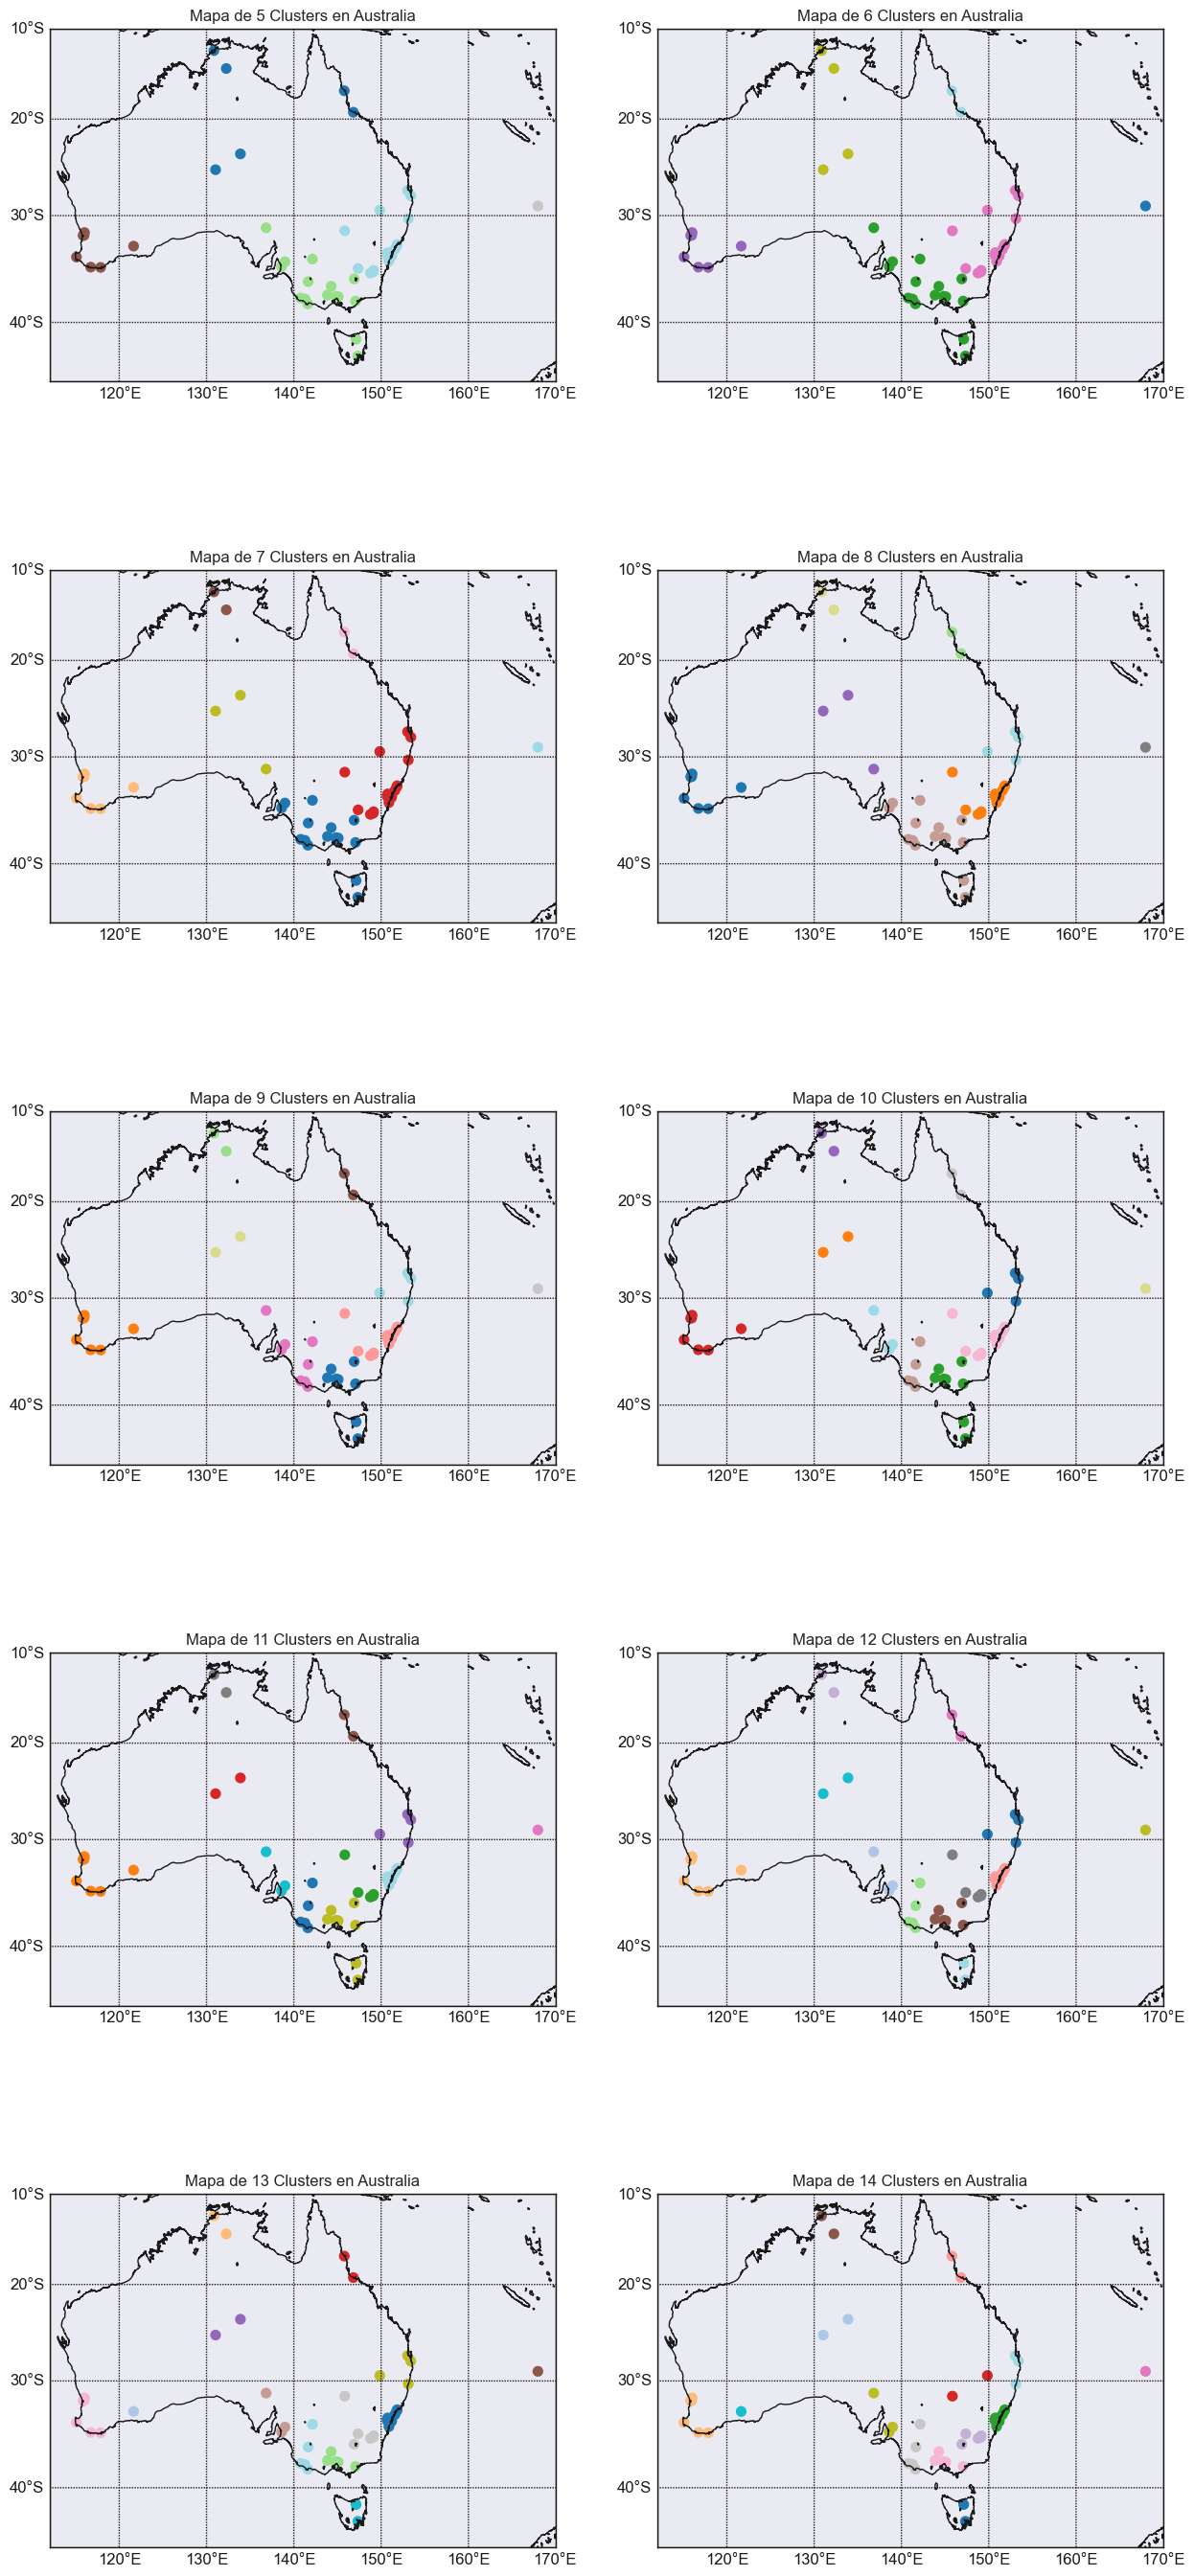

In [328]:
cities=df['Location'].unique().copy()
cities_coord = {'Adelaide': (-34.9285, 138.6007),
                'Albany': (-35.0031, 117.8657),
                'Albury': (-36.0737, 146.9135),
                'AliceSprings': (-23.6980, 133.8807),
                'BadgerysCreek': (-33.8813, 150.7400),
                'Ballarat': (-37.5622, 143.8503),
                'Bendigo': (-36.7570, 144.2794),
                'Brisbane': (-27.4698, 153.0251),
                'Cairns': (-16.9186, 145.7781),
                'Canberra': (-35.2809, 149.1300),
                'Cobar': (-31.4983, 145.8344),
                'CoffsHarbour': (-30.2963, 153.1131),
                'Dartmoor': (-37.9223, 141.2760),
                'Darwin': (-12.4634, 130.8456),
                'GoldCoast': (-28.0167, 153.4000),
                'Hobart': (-42.8821, 147.3272),
                'Katherine': (-14.4644, 132.2630),
                'Launceston': (-41.4545, 147.1317),
                'Melbourne': (-37.8136, 144.9631),
                'MelbourneAirport': (-37.6690, 144.8410),
                'Mildura': (-34.2083, 142.1270),
                'Moree': (-29.4638, 149.8413),
                'MountGambier': (-37.8241, 140.7798),
                'MountGinini': (-35.5294, 148.7720),
                'Newcastle': (-32.9283, 151.7817),
                'Nhil': (-36.3328, 141.6503),
                'NorahHead': (-33.2833, 151.5667),
                'NorfolkIsland': (-29.0408, 167.9547),
                'Nuriootpa': (-34.4667, 138.9833),
                'PearceRAAF': (-31.6675, 116.0158),
                'Penrith': (-33.7581, 150.6950),
                'Perth': (-31.9522, 115.8589),
                'PerthAirport': (-31.9405, 115.9660),
                'Portland': (-38.3511, 141.6056),
                'Richmond': (-33.6000, 150.7500),
                'Sale': (-38.1063, 147.0674),
                'SalmonGums': (-32.9819, 121.6431),
                'Sydney': (-33.8688, 151.2093),
                'SydneyAirport': (-33.9461, 151.1772),
                'Townsville': (-19.2583, 146.8169),
                'Tuggeranong': (-35.4244, 149.0887),
                'Uluru': (-25.3444, 131.0369),
                'WaggaWagga': (-35.1082, 147.3598),
                'Walpole': (-34.9772, 116.7317),
                'Watsonia': (-37.7114, 145.0831),
                'Williamtown': (-32.8150, 151.8428),
                'Witchcliffe': (-34.0264, 115.1000),
                'Wollongong': (-34.4241, 150.8931),
                'Woomera': (-31.1997, 136.8256)}

cities_coord = pd.DataFrame.from_dict(cities_coord, orient='index', columns=['lat', 'lon'])
cities_coord['mean_rain'] = df.groupby('Location')['Rainfall'].mean()
xPos=cities_coord[['lat','lon','mean_rain']].copy()
Nc= range(1, 20)
kmeans= [KMeans(n_clusters=i, n_init=10) for i in Nc]
score = [kmeans[i].fit(xPos).score(xPos) for i in range(len(kmeans))]
# plt.plot(Nc,score)
# plt.xlabel('NumberofClusters')
# plt.ylabel('Score')
# plt.title('ElbowCurve')
# plt.show()

num_clusters = range(5, 15)
num_rows = len(num_clusters) // 2 + len(num_clusters) % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 7))
fig.subplots_adjust(hspace=0.3)

for i, num_cluster in enumerate(num_clusters):
    # Elegir el número óptimo de clusters
    kmeans = KMeans(n_clusters=num_cluster, n_init=10).fit(xPos)
    centroids = kmeans.cluster_centers_

    # Asignar cada punto a su respectivo cluster
    xPos['cluster'] = kmeans.predict(xPos)
    labels = np.unique(xPos['cluster'])
    palette = sns.color_palette("hot", len(labels))
    xPos['cluster'] = xPos['cluster'].astype('category')

    # Calcular la fila y la columna actual
    row = i // 2
    col = i % 2

    # Crear un mapa de Australia para el subplot actual
    ax = axes[row, col]
    m = Basemap(
        projection='merc',
        llcrnrlat=-45, urcrnrlat=-10,
        llcrnrlon=112, urcrnrlon=170,
        resolution='i',
        ax=ax
    )
    m.drawmapboundary()
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(-90., 91., 10.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0, 0, 0, 1])

    # Crear un gráfico de dispersión centrado en Australia
    scatter = m.scatter(
        xPos['lon'], xPos['lat'],
        c=xPos['cluster'], cmap='tab20', s=50,
        latlon=True
    )

    # Configurar título y leyenda para el subplot
    ax.set_title(f'Mapa de {num_cluster} Clusters en Australia')
    #plt.colorbar(scatter, ax=ax, label='Cluster')

# Eliminar subplots vacíos si es necesario
if len(num_clusters) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.show()

Decidimos utilizar 11 clusters debido a que consideramos es la cantidad que mejor se ajusta a los datos sin hacer overfitting.

In [329]:
# Elegir el número óptimo de clusters
kmeans = KMeans(n_clusters=11, n_init=10).fit(xPos)
centroids = kmeans.cluster_centers_

# Asignar cada punto a su respectivo cluster
xPos['cluster'] = kmeans.predict(xPos)
labels = np.unique(xPos['cluster'])
palette = sns.color_palette("hot", len(labels))
xPos['cluster'] = xPos['cluster'].astype('category')

df['Cluster']=df['Location'].map(xPos['cluster'])
df.to_csv('files/weatherAUS_cluster.csv', index=False)

## Corrigiendo datos vacíos ##

Dado que estamos hablando de variables climáticas y se puede considerar que estan no presentan grandes variaciones para regiones cercanas, al clusterizar las ciudades podemos estimar aquellos datos vacíos como la media de los datos de las ciudades del mismo cluster para la misma fecha.

In [330]:
numeric_columns = df.select_dtypes(include=[float, int]).columns
non_numeric_columns = df.select_dtypes(include=[object]).columns

In [331]:
# Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la media del grupo
df_numeric = df.groupby(['Cluster', 'Date'])[numeric_columns].transform(lambda x: x.fillna(x.mean()))

# Asignar los valores llenos al DataFrame original
df[numeric_columns] = df_numeric

# Función para llenar los valores nulos con la moda
def fill_with_mode(x):
    mode_value = x.mode()
    if len(mode_value) > 0:
        return x.fillna(mode_value.iloc[0])
    else:
        return x

# Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la moda del grupo
df_non_numeric = df.groupby(['Cluster', 'Date'])[non_numeric_columns].transform(fill_with_mode)

# Asignar los valores llenos al DataFrame original
df[non_numeric_columns] = df_non_numeric

In [332]:
vacios_transformado=df.isna().sum()
comparison_df = pd.DataFrame({'vacios_antes': vacios_original, 'vacios_despues': vacios_transformado})
total_datos = len(df)
comparison_df['porcentaje recuperado'] = 100 * (1 - comparison_df['vacios_despues'] / comparison_df['vacios_antes'])
comparison_df['porcentaje recuperado'] = comparison_df['porcentaje recuperado'].apply(lambda x: f'{x:.2f}%')
comparison_df['porcentaje_completo'] = 100 * (1 - comparison_df['vacios_despues'] / total_datos)
comparison_df['porcentaje_completo'] = comparison_df['porcentaje_completo'].apply(lambda x: f'{x:.2f}%')


# Mostrar el DataFrame con la comparación
comparison_df

vacios_antes  vacios_despues porcentaje recuperado  \
Cloud3pm               59336.0            7520                87.33%   
Cloud9am               55870.0            6312                88.70%   
Cluster                    NaN               0                  nan%   
Date                       0.0               0                  nan%   
Evaporation            62754.0            3946                93.71%   
Humidity3pm             4505.0              44                99.02%   
Humidity9am             2653.0              45                98.30%   
Location                   0.0               0                  nan%   
MaxTemp                 1253.0              44                96.49%   
MinTemp                 1484.0              44                97.04%   
Pressure3pm            15024.0            3006                79.99%   
Pressure9am            15061.0            3010                80.01%   
RainToday               3260.0             112                96.56%   
RainTomorrow            3259.0             112                96.56%   
Rainfall                3260.0             112                96.56%   
RainfallTomorrow        3259.0             112                96.56%   
Sunshine               69796.0            5476                92.15%   
Temp3pm                 3607.0              42                98.84%   
Temp9am                 1766.0              42                97.62%   
WindDir3pm              4226.0              89                97.89%   
WindDir9am             10562.0             297                97.19%   
WindGustDir            10316.0             211                97.95%   
WindGustSpeed          10253.0             208                97.97%   
WindSpeed3pm            3061.0              76                97.52%   
WindSpeed9am            1767.0              82                95.36%   

                 porcentaje_completo  
Cloud3pm                      94.83%  
Cloud9am                      95.66%  
Cluster                      100.00%  
Date                         100.00%  
Evaporation                   97.29%  
Humidity3pm                   99.97%  
Humidity9am                   99.97%  
Location                     100.00%  
MaxTemp                       99.97%  
MinTemp                       99.97%  
Pressure3pm                   97.93%  
Pressure9am                   97.93%  
RainToday                     99.92%  
RainTomorrow                  99.92%  
Rainfall                      99.92%  
RainfallTomorrow              99.92%  
Sunshine                      96.23%  
Temp3pm                       99.97%  
Temp9am                       99.97%  
WindDir3pm                    99.94%  
WindDir9am                    99.80%  
WindGustDir                   99.85%  
WindGustSpeed                 99.86%  
WindSpeed3pm                  99.95%  
WindSpeed9am                  99.94%

Podemos notar que el método fue efectivo, habiendo recuperado grandes cantidades de datos y con registros totales completos que se acercan al 100%. Ahora podríamos considerar eliminar los registros que presenten valores nulos y no deberíamos perder grandes vólumenes de información.

In [333]:
df_sin_nan = df.dropna()
df_sin_nan.to_csv('files/weatherAUS_sin_nan.csv', index=False)
df=df_sin_nan.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135750 entries, 0 to 144987
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              135750 non-null  datetime64[ns]
 1   Location          135750 non-null  object        
 2   MinTemp           135750 non-null  float64       
 3   MaxTemp           135750 non-null  float64       
 4   Rainfall          135750 non-null  float64       
 5   Evaporation       135750 non-null  float64       
 6   Sunshine          135750 non-null  float64       
 7   WindGustDir       135750 non-null  object        
 8   WindGustSpeed     135750 non-null  float64       
 9   WindDir9am        135750 non-null  object        
 10  WindDir3pm        135750 non-null  object        
 11  WindSpeed9am      135750 non-null  float64       
 12  WindSpeed3pm      135750 non-null  float64       
 13  Humidity9am       135750 non-null  float64       
 14  Humi

## Unificando Variables relacionadas ##

Existen relaciones intrínsecas entre ciertas variables, para poder hacer predicciones con ellas decidimos unificarlas en otras nuevas. Construimos un vector para aquellas variables que presentaban módulo y dirección, para luego tomar sus componentes como nuevos parámetros. Tomamos la diferencia de presiones también como nueva variable, el mismo procedimiento lo hacemos para la humedad. Para las variables de nubosidad construimos una nueva variable categórica que representara el estado del cielo en ese día.

In [334]:
def vector_coordinates(df,column,dir,speed):
    direcciones = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }
    velocidad=df[speed]
    df[column+'u'] = -velocidad * np.sin(np.deg2rad(df[dir].map(direcciones)))
    df[column+'v'] = -velocidad * np.cos(np.deg2rad(df[dir].map(direcciones)))
    return df

def definir_estado_del_cielo(row):
    if row['Cloud9am'] == 0 and row['Cloud3pm'] == 0:
        return 'Despejado'
    elif row['Cloud9am'] <= 4 and row['Cloud3pm'] <= 4:
        return 'Parcialmente Nublado'
    elif row['Cloud9am'] <= 7 and row['Cloud3pm'] <= 7:
        return 'Nublado'
    else:
        return 'Muy Nublado'

In [335]:
df=vector_coordinates(df,'Wind9am','WindDir9am','WindSpeed9am')
df=vector_coordinates(df,'Wind3pm','WindDir3pm','WindSpeed3pm')
df=vector_coordinates(df,'WindGust','WindGustDir','WindGustSpeed')
df['Pressure_Difference'] = df['Pressure3pm'] - df['Pressure9am']
df['Humidity_Difference'] = df['Humidity3pm'] - df['Humidity9am']
df['Estado_Cielo'] = df.apply(definir_estado_del_cielo, axis=1)
df.drop(['Cloud3pm','Cloud9am','Humidity3pm','Humidity9am','WindSpeed9am','WindSpeed3pm','WindGustSpeed','WindDir9am','WindDir3pm','WindGustDir','Pressure3pm','Pressure9am','Temp3pm','Temp9am'], axis=1, inplace=True)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01   Albury     13.4     22.9       0.6          8.6     11.95   
1      2008-12-02   Albury      7.4     25.1       0.0         12.5     13.05   
2      2008-12-03   Albury     12.9     25.7       0.0          9.1     10.60   
3      2008-12-04   Albury      9.2     28.0       0.0         10.5      6.50   
4      2008-12-05   Albury     17.5     32.3       1.0          5.7      7.40   
...           ...      ...      ...      ...       ...          ...       ...   
144981 2016-04-20    Uluru     18.8     31.7       0.0          8.0      9.90   
144984 2016-04-23    Uluru     16.9     28.4       0.0         18.4     11.00   
144985 2016-04-24    Uluru     12.1     27.3       0.0          8.2     11.00   
144986 2016-04-25    Uluru      9.6     28.8       0.0          7.8     11.00   
144987 2016-04-26    Uluru     11.0     32.5       0.0          8.0     11.00   

       RainToday RainTomorrow  RainfallTomorrow Cluster      Wind9amu  \
0             No           No               0.0       5  2.000000e+01   
1             No           No               0.0       5  1.530734e+00   
2             No           No               0.0       5  1.900000e+01   
3             No           No               1.0       5 -7.778175e+00   
4             No           No               0.2       5 -6.467157e+00   
...          ...          ...               ...     ...           ...   
144981        No           No               0.0       7 -2.081900e-15   
144984        No           No               0.0       7 -1.847759e+01   
144985        No           No               0.0       7 -2.032535e+01   
144986        No           No               0.0       7 -1.300000e+01   
144987        No           No               0.0       7 -1.100000e+01   

            Wind9amv   Wind3pmu      Wind3pmv  WindGustu     WindGustv  \
0       3.673940e-15  22.173109 -9.184402e+00  44.000000  8.082669e-15   
1      -3.695518e+00  20.325350  8.419036e+00  40.650699 -1.683807e+01   
2       3.490243e-15  24.020868  9.949769e+00  42.498458  1.760344e+01   
3       7.778175e+00  -9.000000 -5.510911e-16 -16.970563 -1.697056e+01   
4      -2.678784e+00  14.142136 -1.414214e+01  41.000000  7.531578e-15   
...              ...        ...           ...        ...           ...   
144981  1.700000e+01 -13.435029 -1.343503e+01  11.863186  2.864027e+01   
144984  7.653669e+00 -18.477591  7.653669e+00 -31.000000 -1.898203e-15   
144985 -8.419036e+00 -19.000000 -1.163414e-15 -31.000000 -1.898203e-15   
144986 -7.960204e-16  -3.444151 -8.314916e+00 -30.000000 -1.836970e-15   
144987 -6.735557e-16  16.970563 -1.697056e+01  -0.000000 -3.300000e+01   

        Pressure_Difference  Humidity_Difference          Estado_Cielo  
0                      -0.6                -49.0           Muy Nublado  
1                      -2.8                -19.0  Parcialmente Nublado  
2                       1.1                 -8.0               Nublado  
3                      -4.8                -29.0               Nublado  
4                      -4.8                -49.0           Muy Nublado  
...                     ...                  ...                   ...  
144981                 -2.8                -20.0           Muy Nublado  
144984                 -4.4                -20.0  Parcialmente Nublado  
144985                 -4.8                -21.0             Despejado  
144986                 -4.6                -15.0             Despejado  
144987                 -4.9                -16.0  Parcialmente Nublado  

[135750 rows x 20 columns]

# Visualización y análisis de datos #

In [336]:
def city_dataframe(city):
    df_city = df[df['Location'] == city]
    return df_city

def cluster_dataframe(df,cluster):
    df_cluster = df[df['Cluster'] == cluster]
    return df_cluster

def plot_temperature(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x="Date", y="MaxTemp", data=df, color='red')
    sns.lineplot(x="Date", y="MinTemp", data=df, color='blue')
    plt.xticks(rotation=90)
    plt.xticks(np.arange(0, len(df), 50))
    plt.show()

def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_rows, 20 * num_cols))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=30)
        axs[row, col_idx].set_ylabel("Count",fontsize=20)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=20)
        axs[row, col_idx].tick_params(axis='y', labelsize=20)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas: {df['Location'].iloc[0]}", fontsize=30)
    else:
        fig.suptitle(f"Histogramas de variales numéricas", fontsize=30)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def matriz_correlacion(df):
    corr = df.select_dtypes(include=[float, int]).corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 15))

    ax = sns.heatmap(
        corr,
        #mask = mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        annot_kws={'size': 15},
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación: {df['Location'].iloc[0]}", fontsize=30)
    else:
        ax.set_title("Matriz de Correlación", fontsize=30)
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def global_boxplots(df):
    # Asegúrate de que todas las columnas sean numéricas
    columnas_numericas = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=['number'])
    
    if columnas_numericas.empty:
        print("No hay columnas numéricas en el DataFrame.")
        return
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title("Boxplots para todas las variables")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()

def date_boxplots(df, year, month):
    # Asegúrate de que la columna 'Date' sea de tipo datetime
    df1 = df.drop(['Rainfall','RainfallTomorrow'],axis=1).copy()  # Realizar una copia del DataFrame para evitar el SettingWithCopyWarning

    # Filtrar el DataFrame por el año y el mes específicos
    filtered_df1 = df1[(df1['Date'].dt.year == year) & (df1['Date'].dt.month == month)]
    
    if filtered_df1.empty:
        print("No hay datos para el año y mes especificados.")
        return
    
    # Seleccionar solo las columnas numéricas
    columnas_numericas = filtered_df1.select_dtypes(include=['number'])
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Obtener la cantidad de datos disponibles
    cantidad_datos = len(filtered_df1)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title(f"Boxplots para {year}/{month}")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()


def scatter_plot(df):
    numeric_cols = df.drop(['RainfallTomorrow'], axis=1).select_dtypes(include=['number'])
    num_plots = len(numeric_cols.columns)
    
    # Determina el número de filas y columnas para la matriz
    num_rows = (num_plots + 2) // 3  # Redondea hacia arriba
    num_cols = min(num_plots, 3)

    # Aumenta el tamaño de la figura
    figsize = (20, num_rows * 6)  # Aumenta la altura de la figura
    
    # Crea una figura de Matplotlib con subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, col in enumerate(numeric_cols.columns):
        row = i // num_cols
        col_num = i % num_cols  # Cambia el nombre de la variable para evitar la confusión

        # Selecciona el subplot actual
        ax = axes[row, col_num]

        # Crea el gráfico de dispersión en el subplot
        sns.scatterplot(x=col, y='RainfallTomorrow', data=df, hue='Cluster', ax=ax)
        ax.set_title(col)  # Configura el título del subplot

    # Elimina subplots no utilizados
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col_num = i % num_cols
        fig.delaxes(axes[row, col_num])

    plt.tight_layout()
    plt.show()
    
def graficos(df):
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles en el DataFrame: {len(df)}")
    plot_variables(df)
    matriz_correlacion(df)
    global_boxplots(df)
    scatter_plot(df)

Usamos la función gráfico para plotear distintos gráficos para el dataframe.

Cantidad de datos disponibles en el DataFrame: 135750


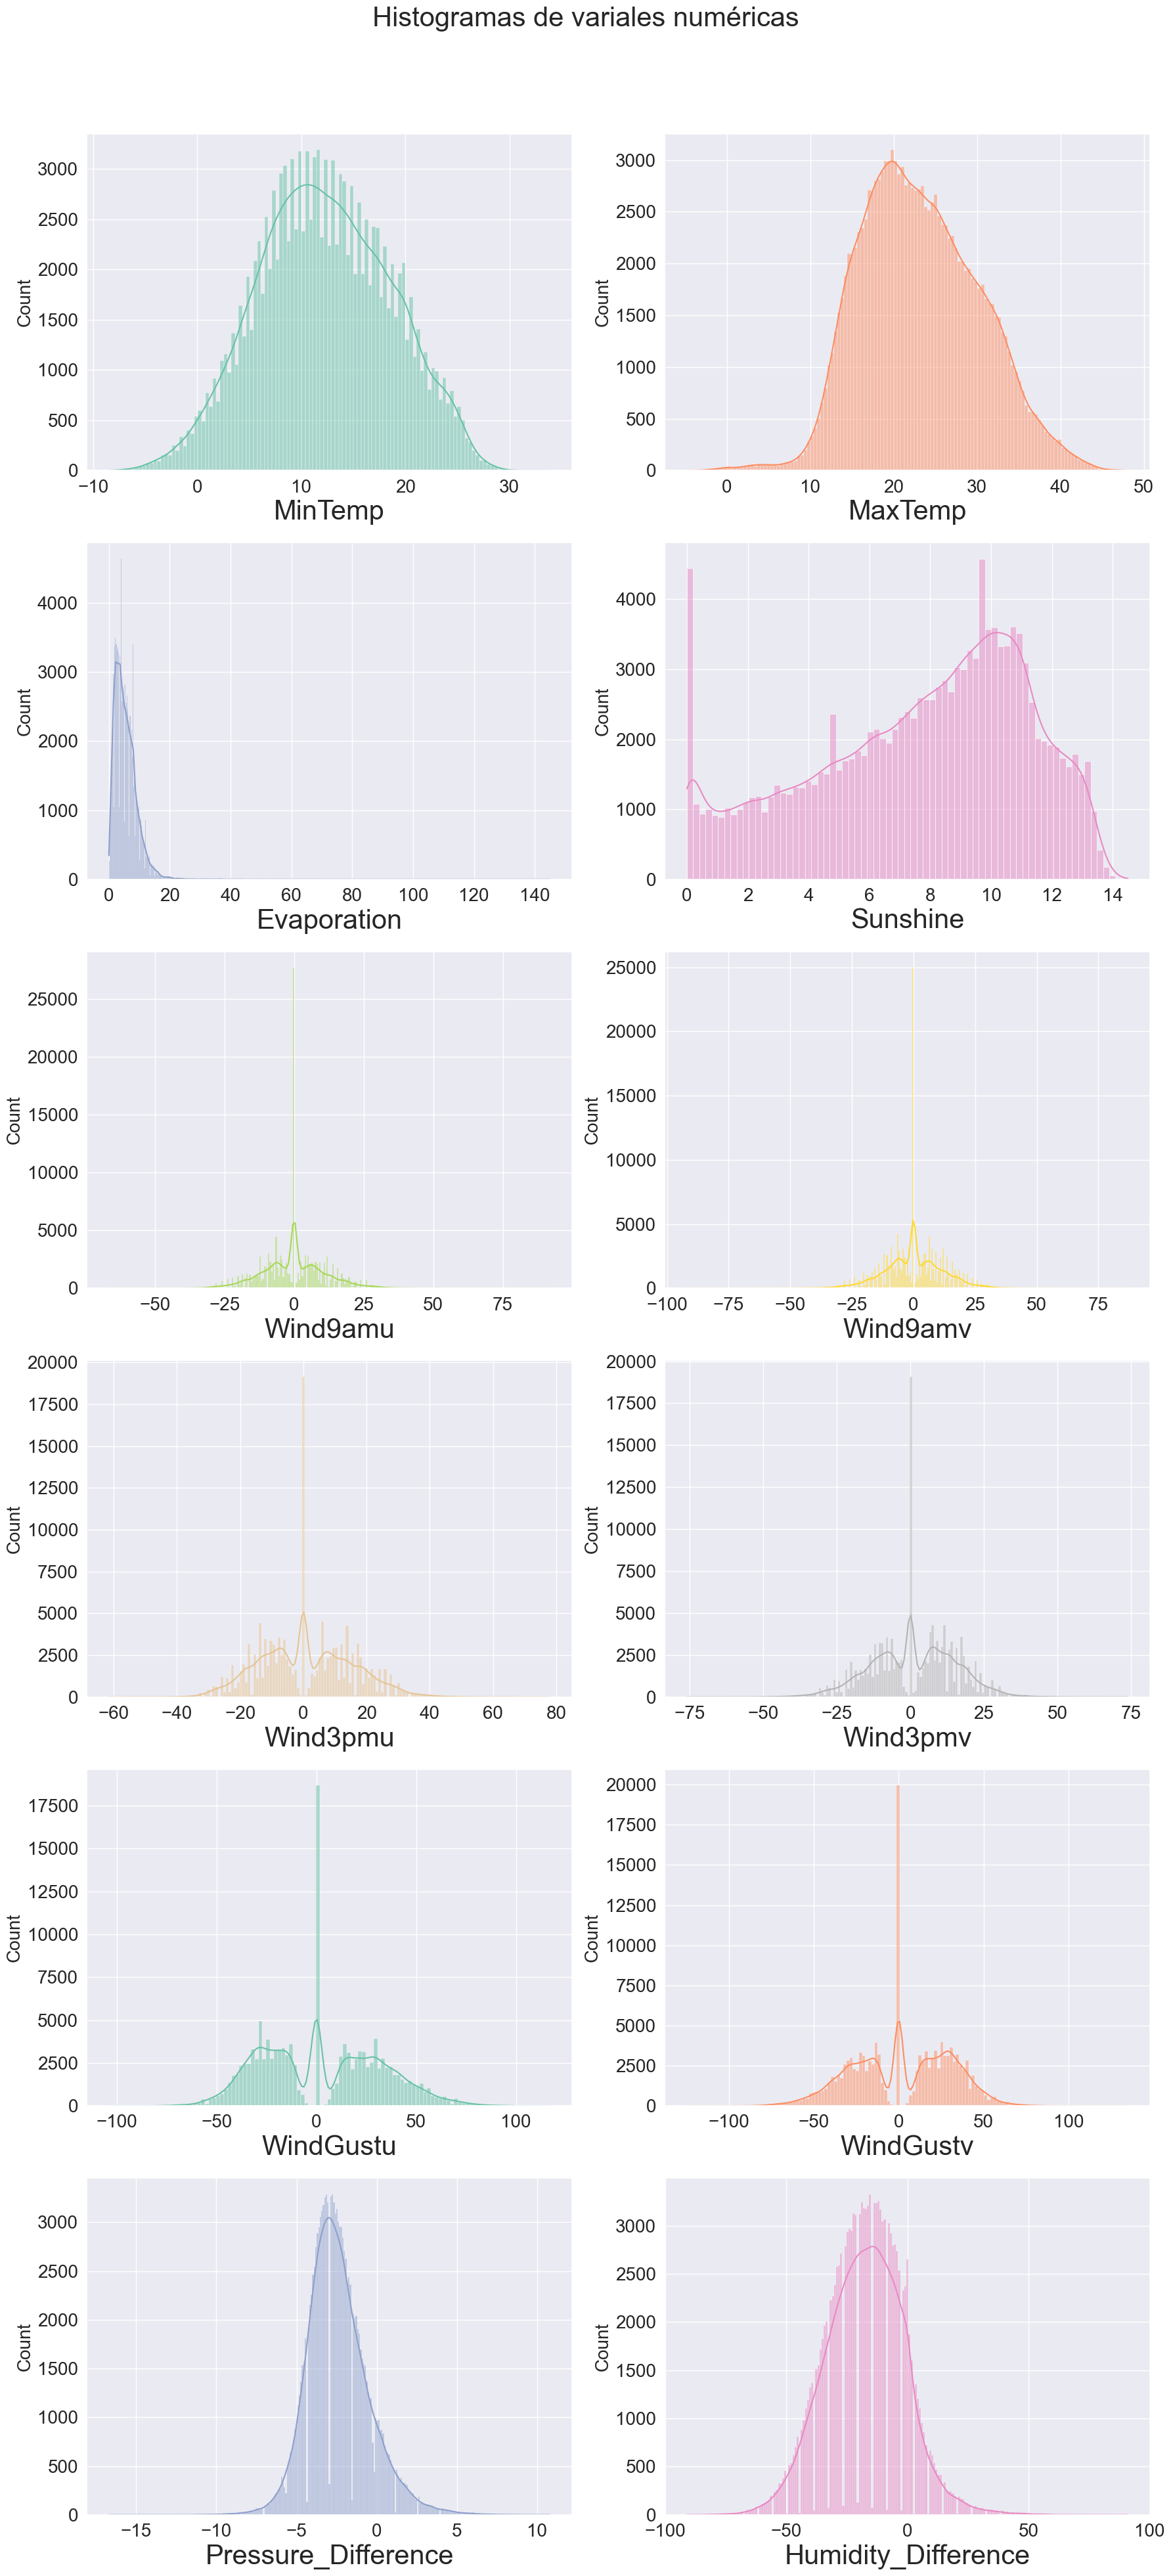

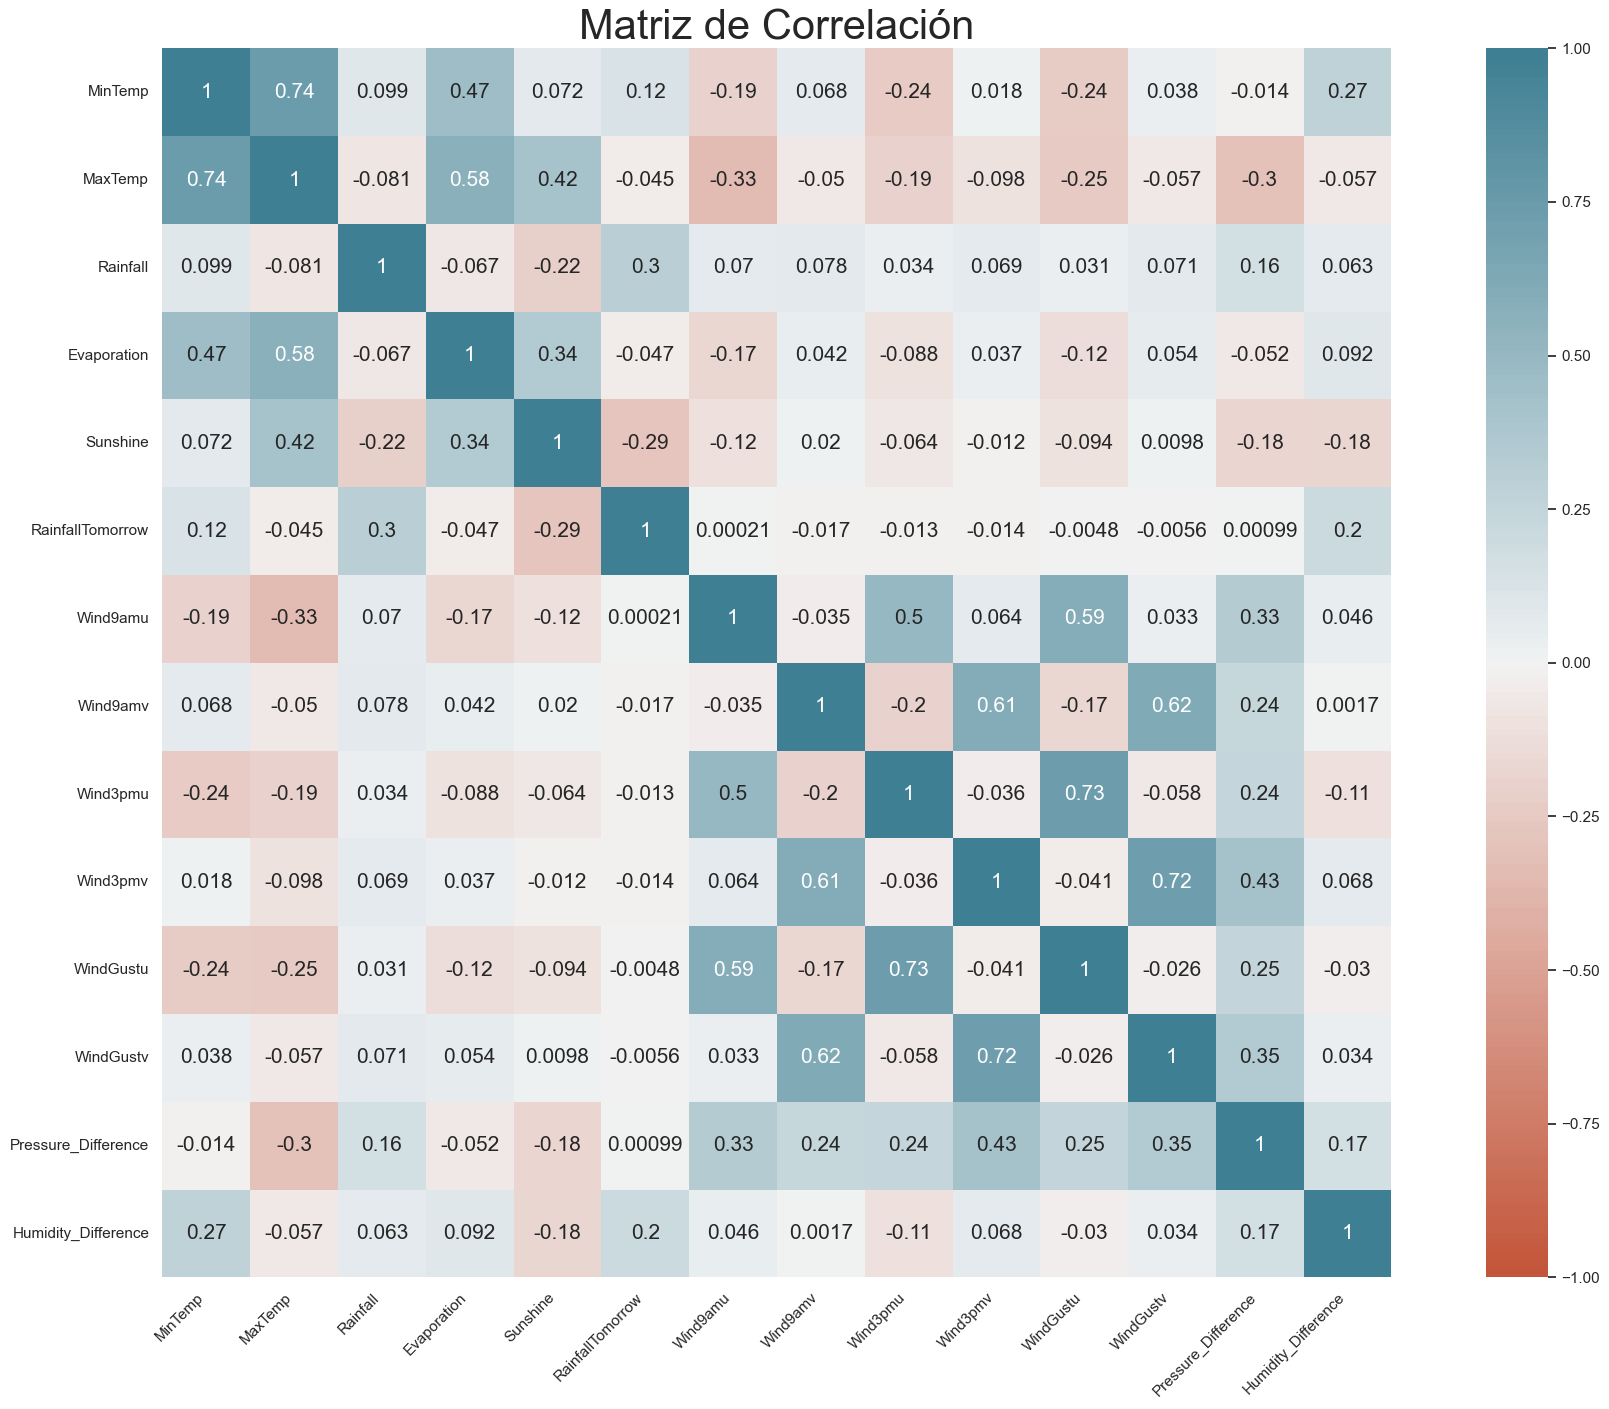

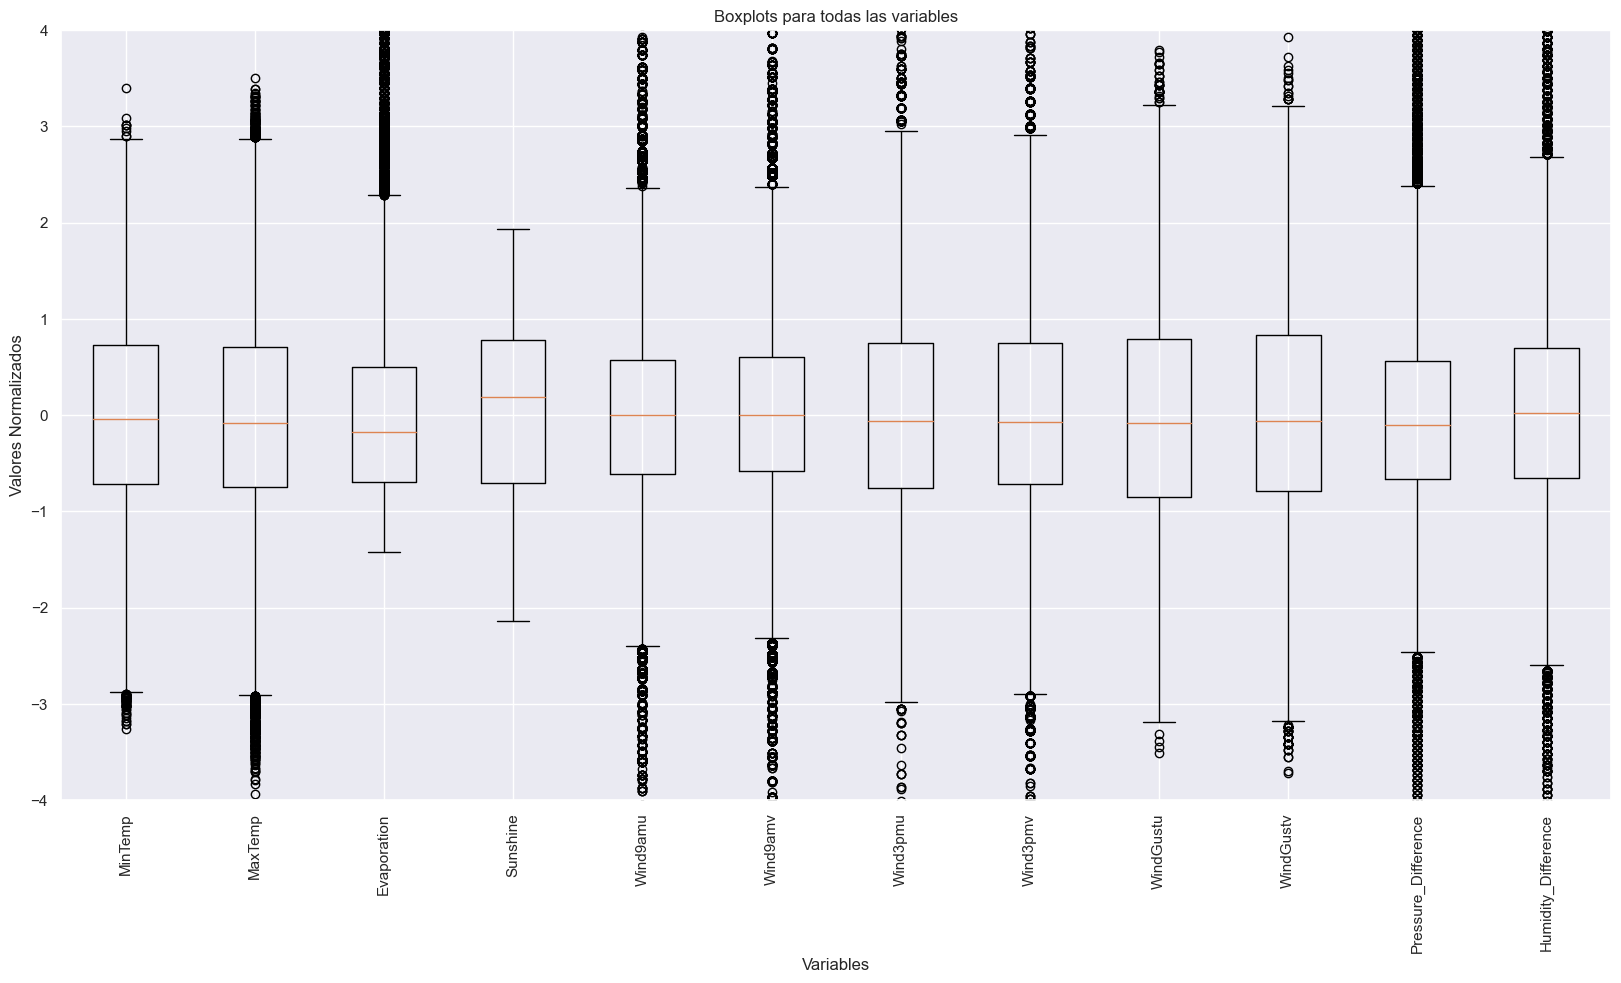

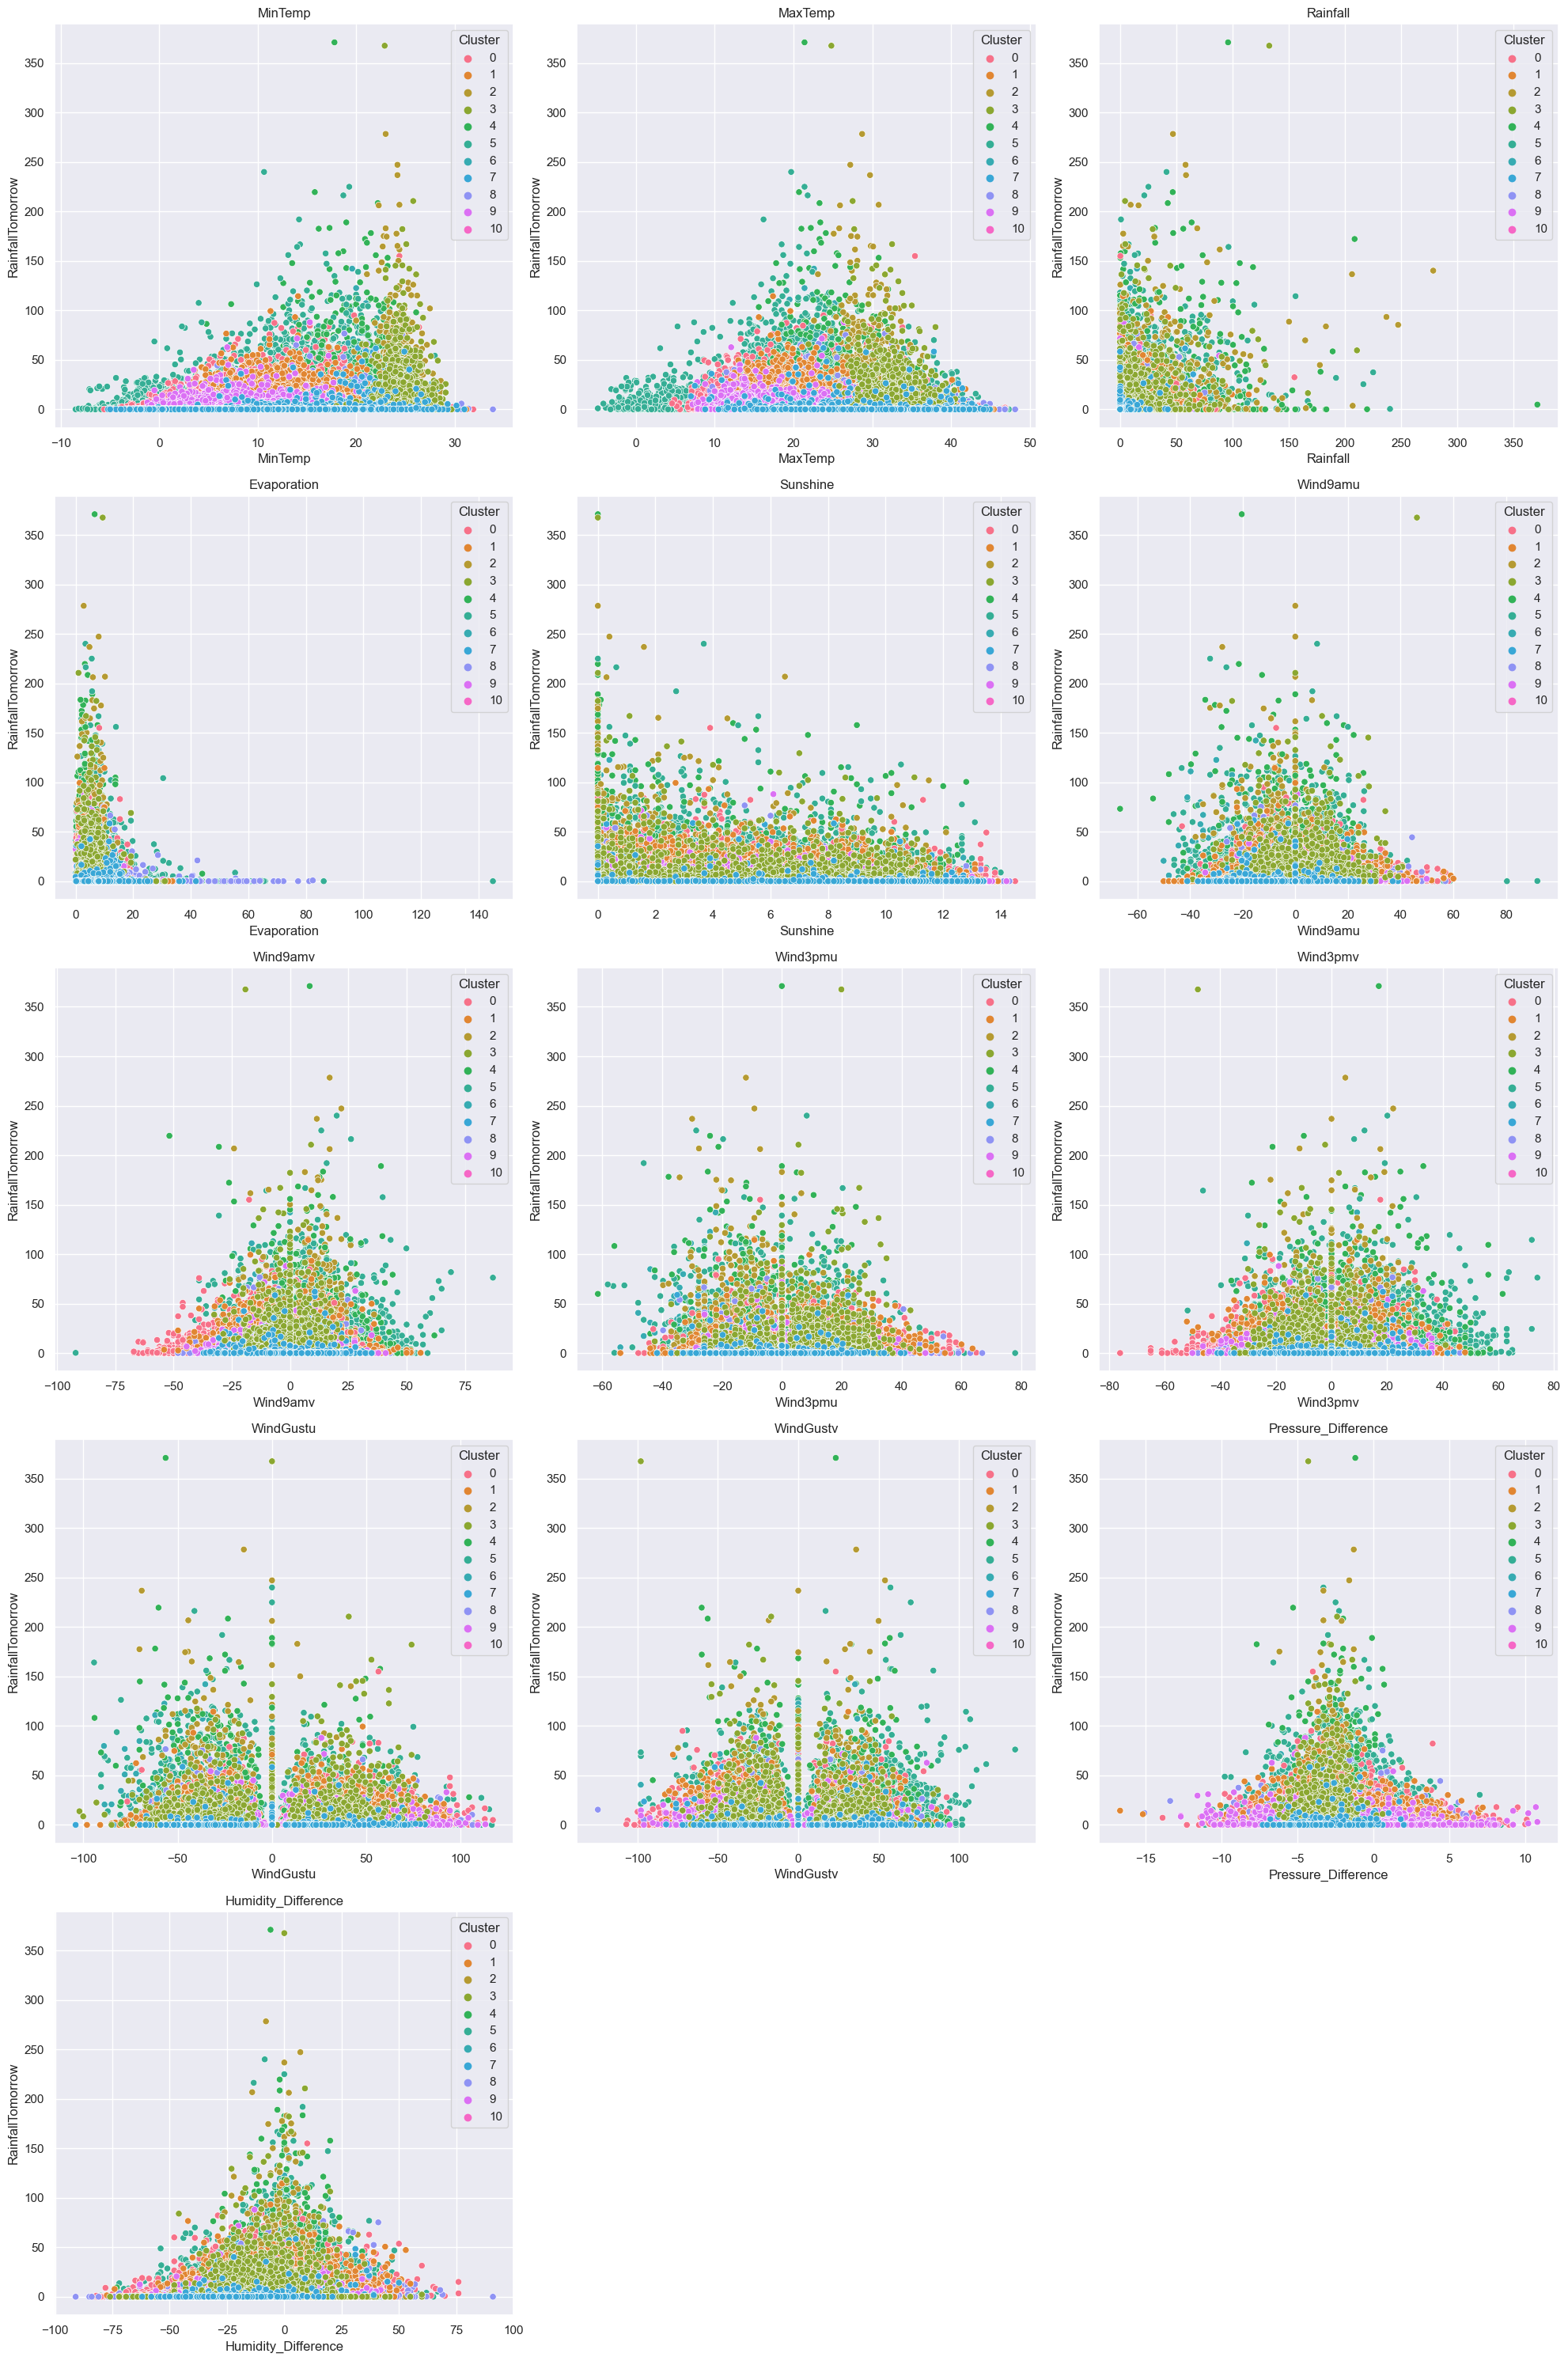

In [337]:
graficos(df)

Analizan

Podemos usar la misma función para visualizar los datos de un cluster particular.

Cantidad de datos disponibles en el DataFrame: 31933


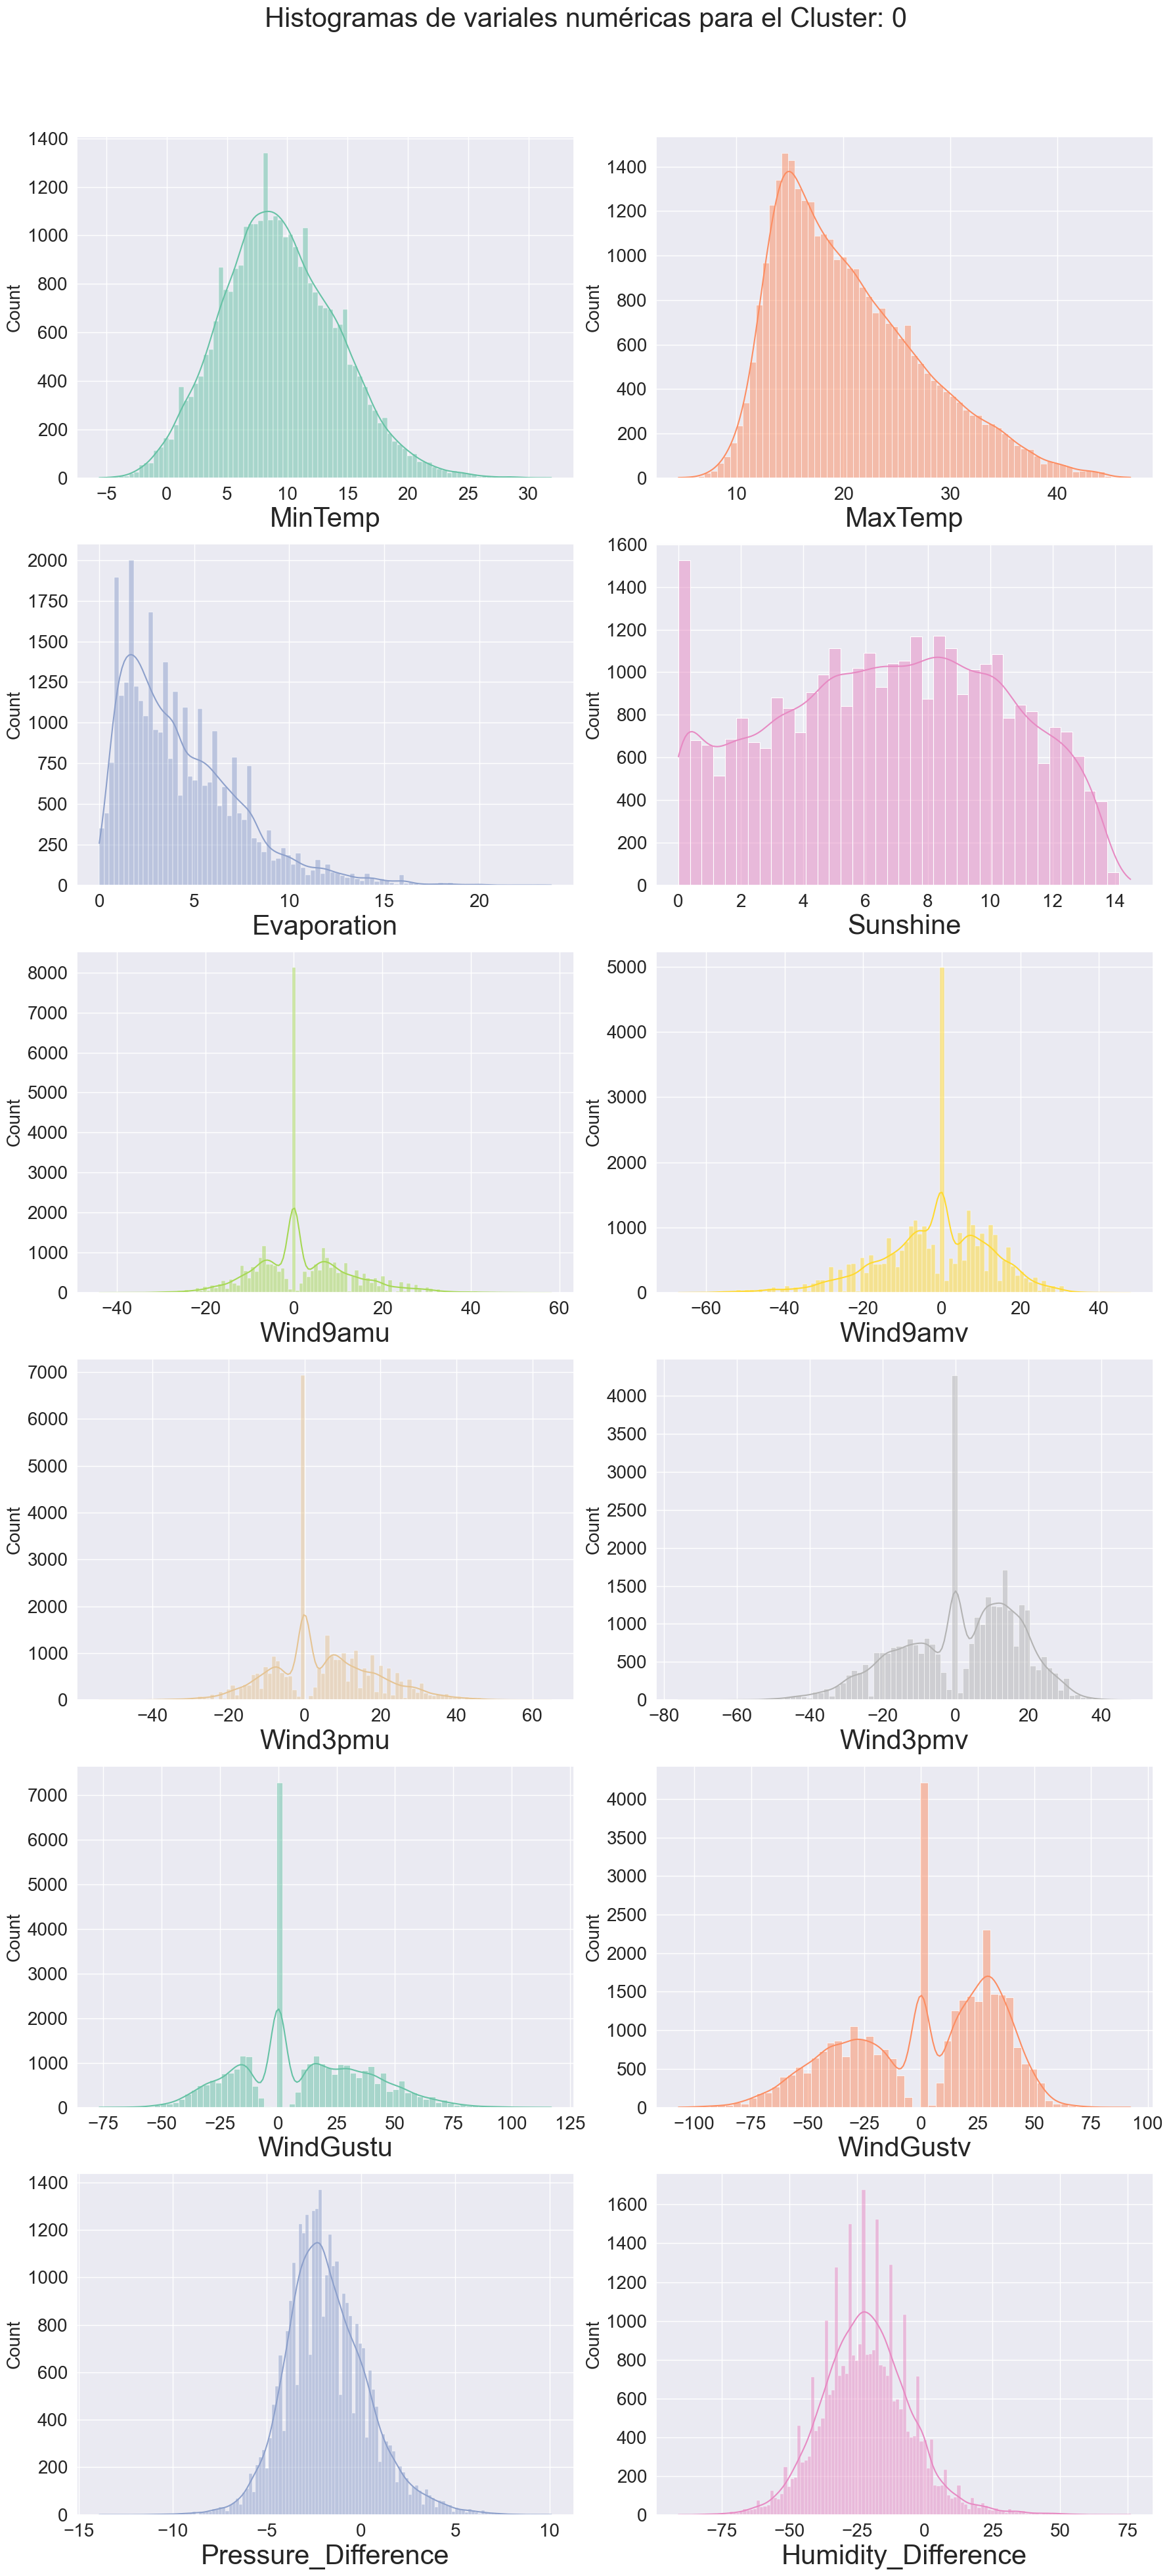

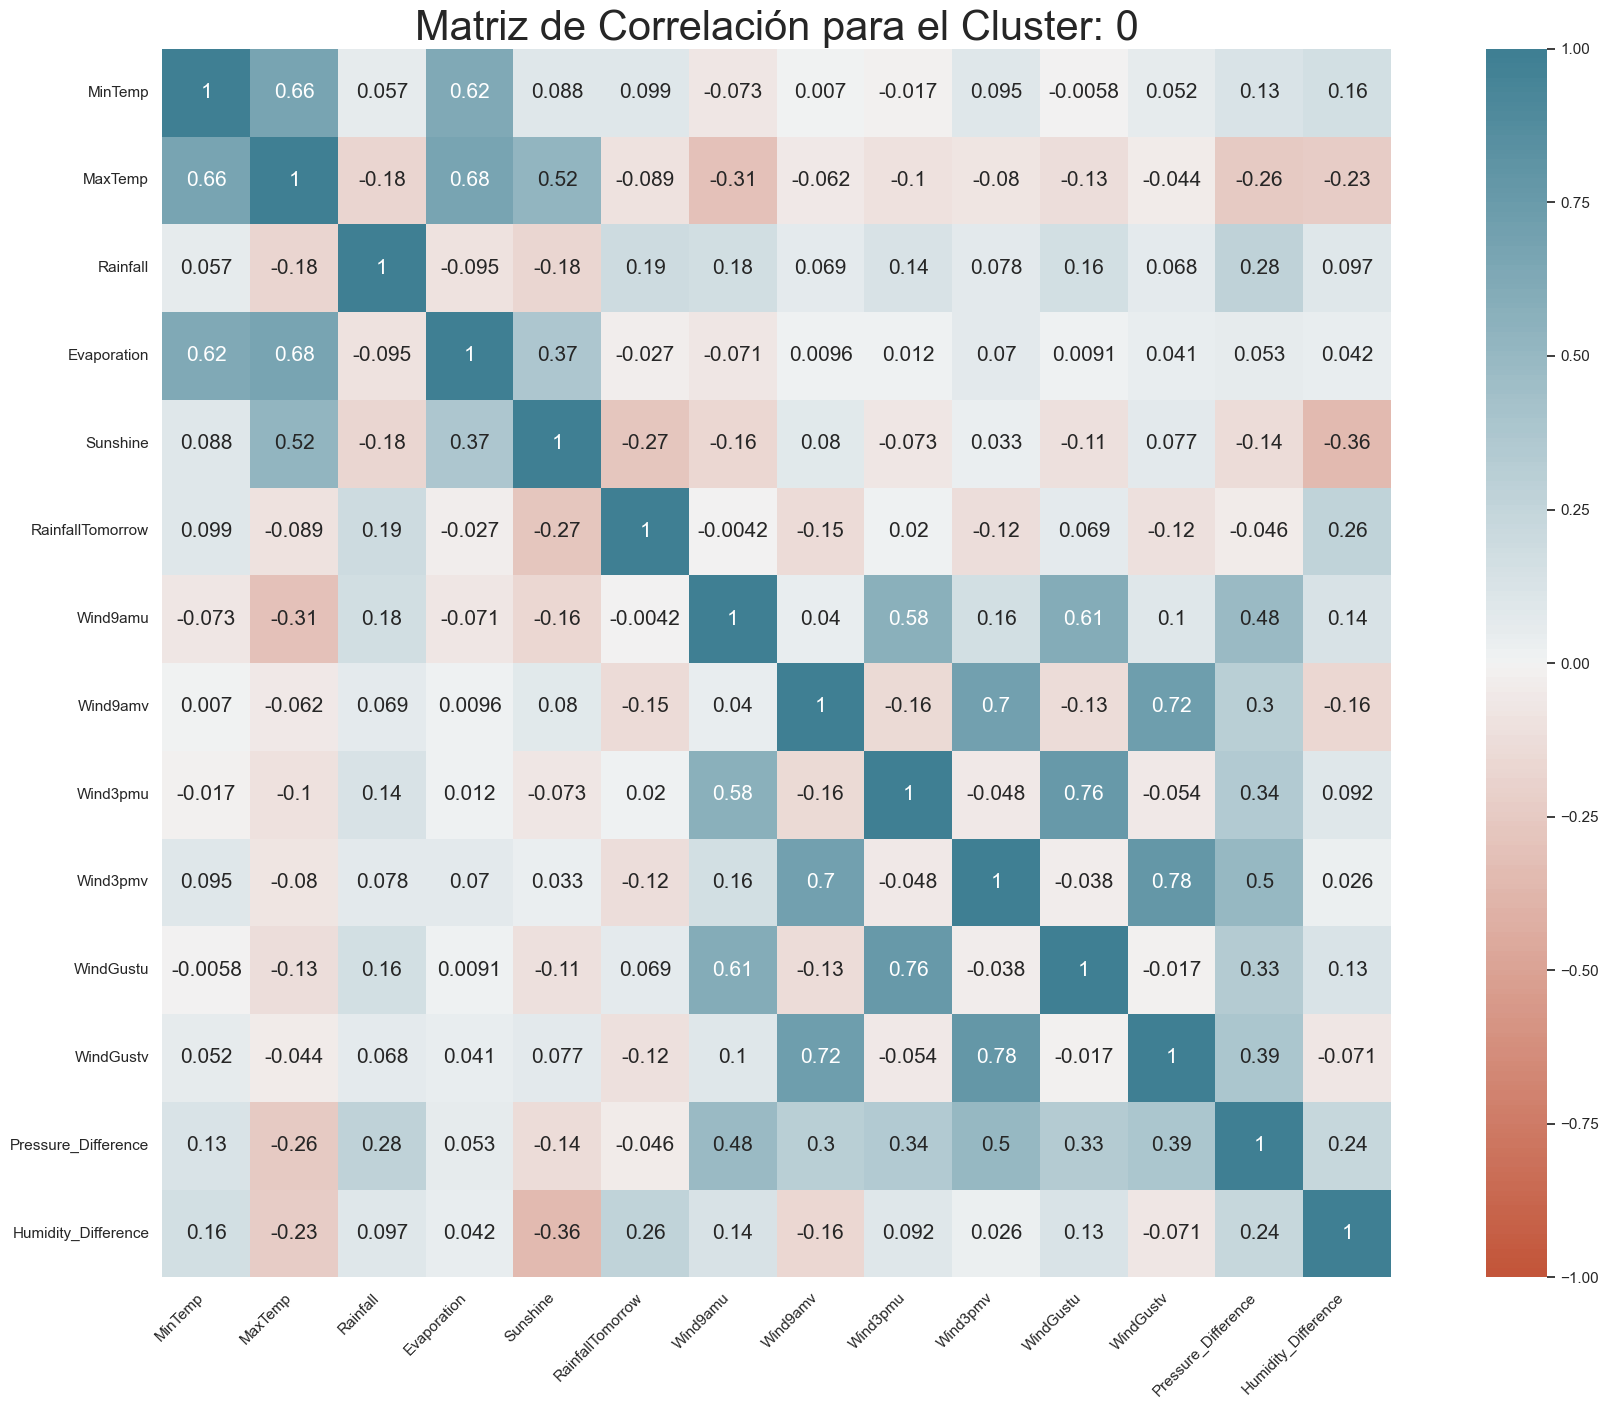

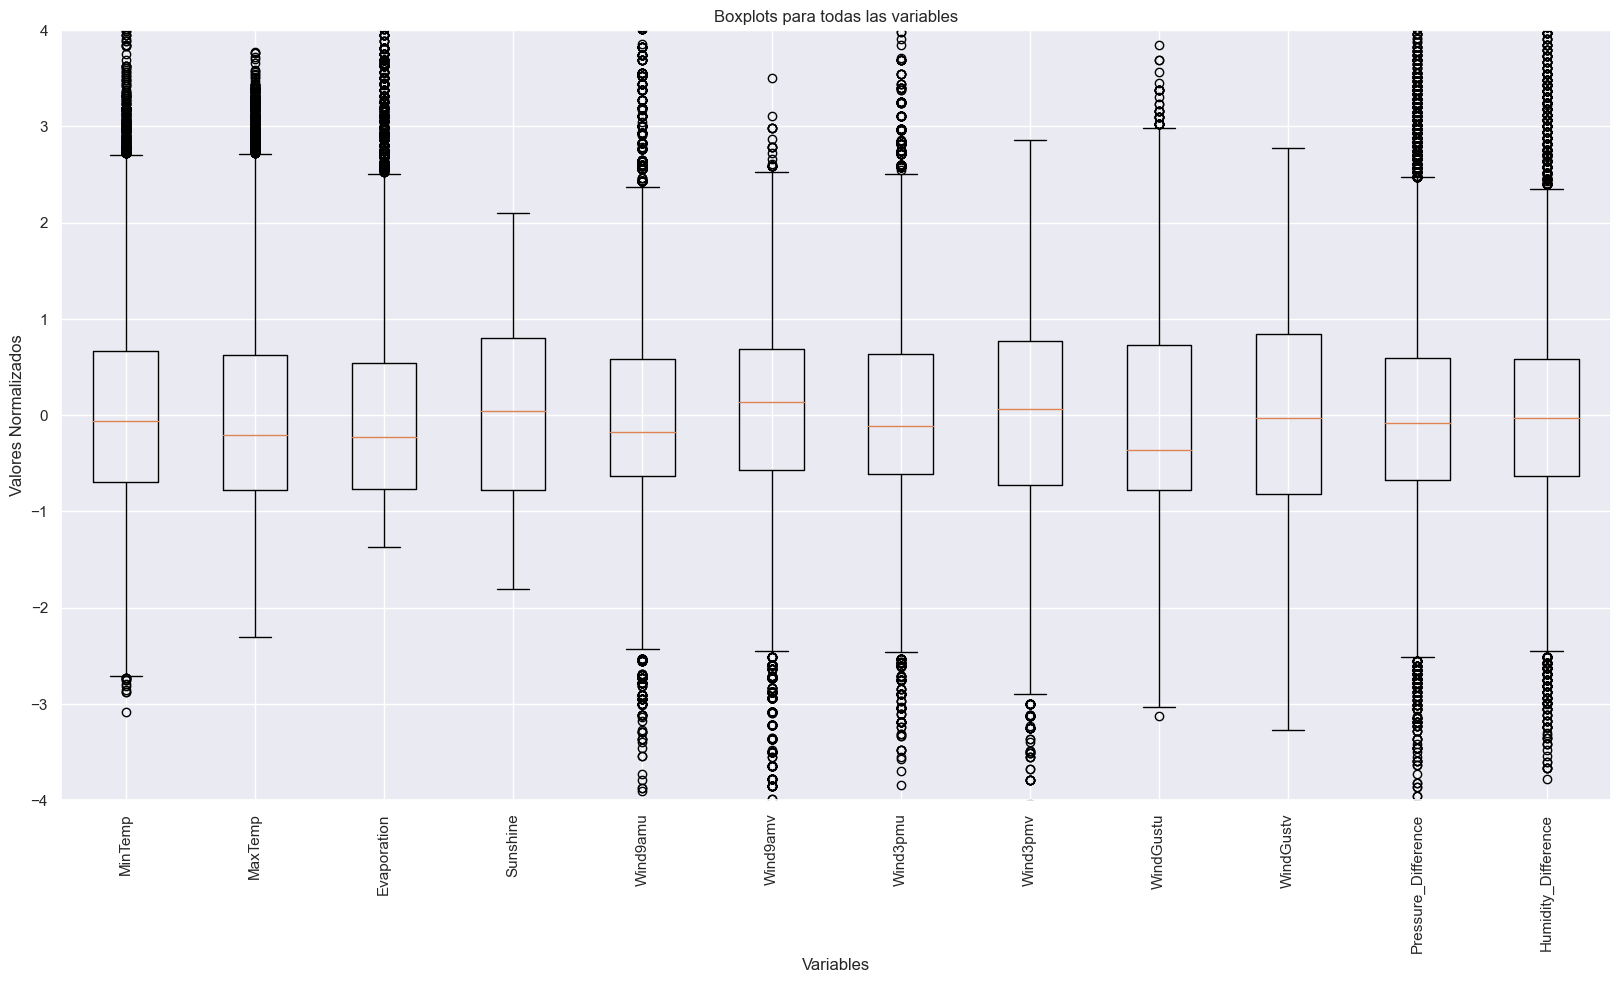

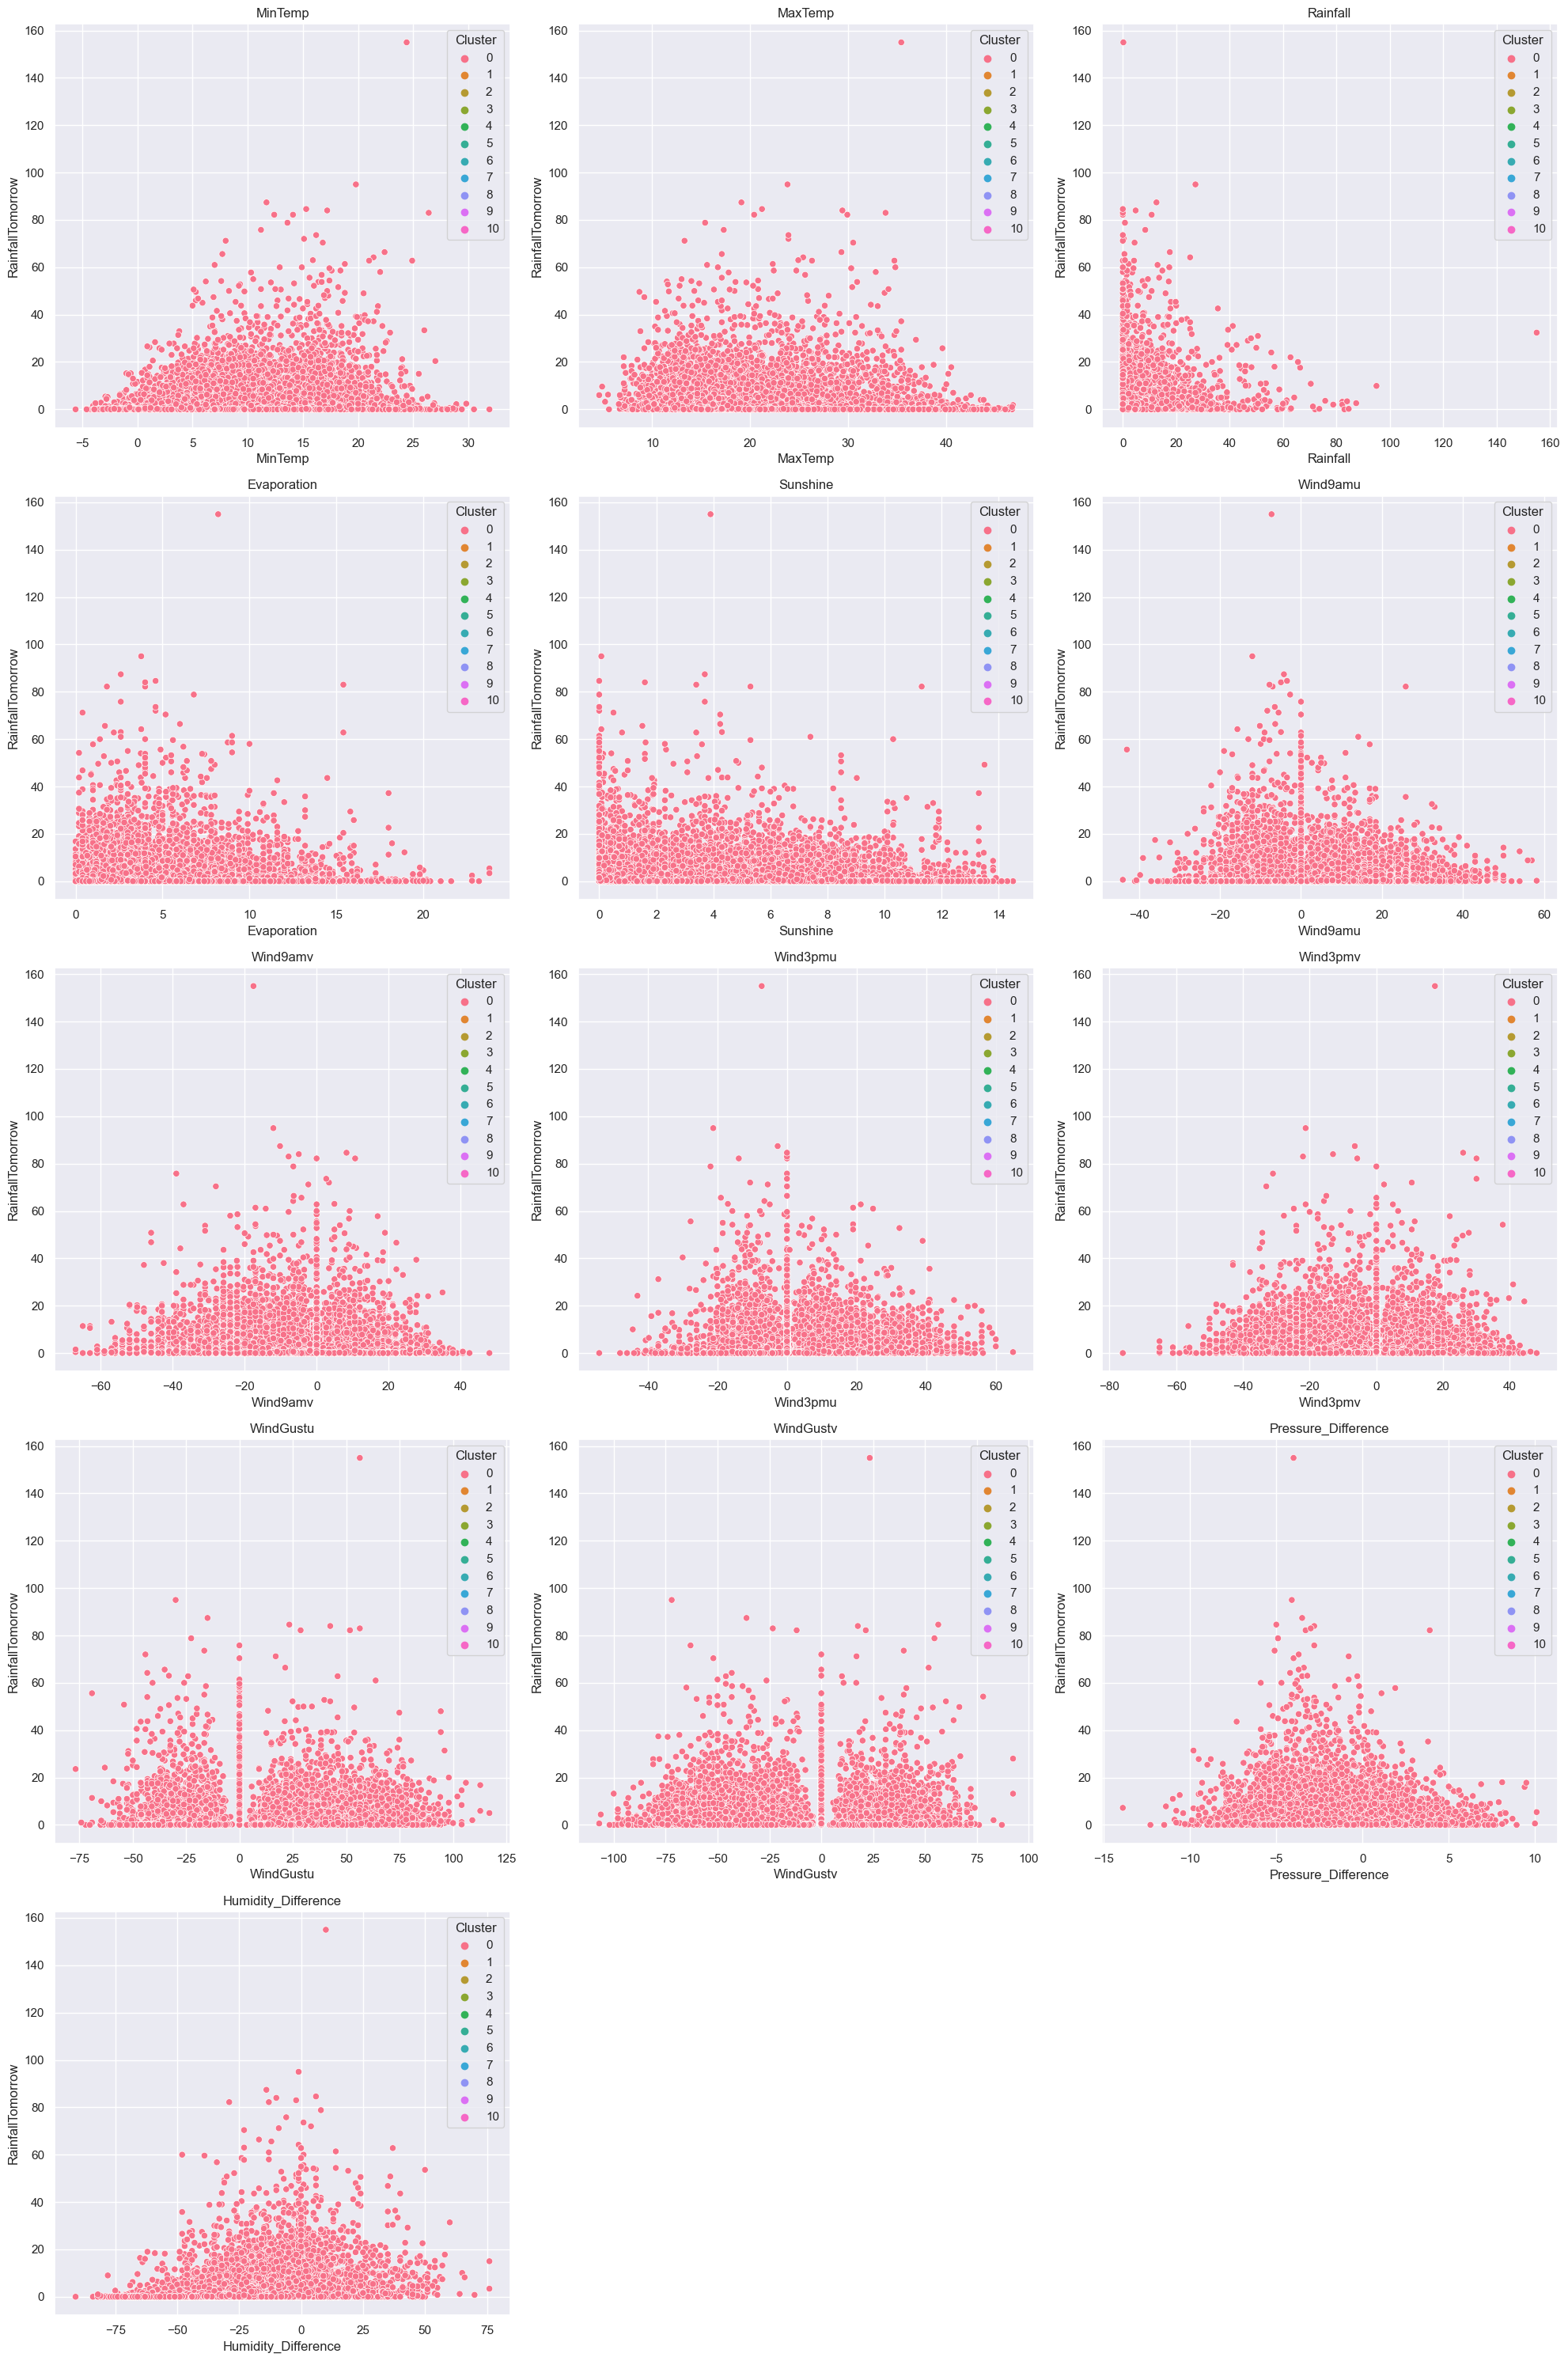

In [338]:
graficos(cluster_dataframe(df,0))

Y también tenemos un método que nos permite ver los boxplot para un mes particular, en caso de que sea necesario.

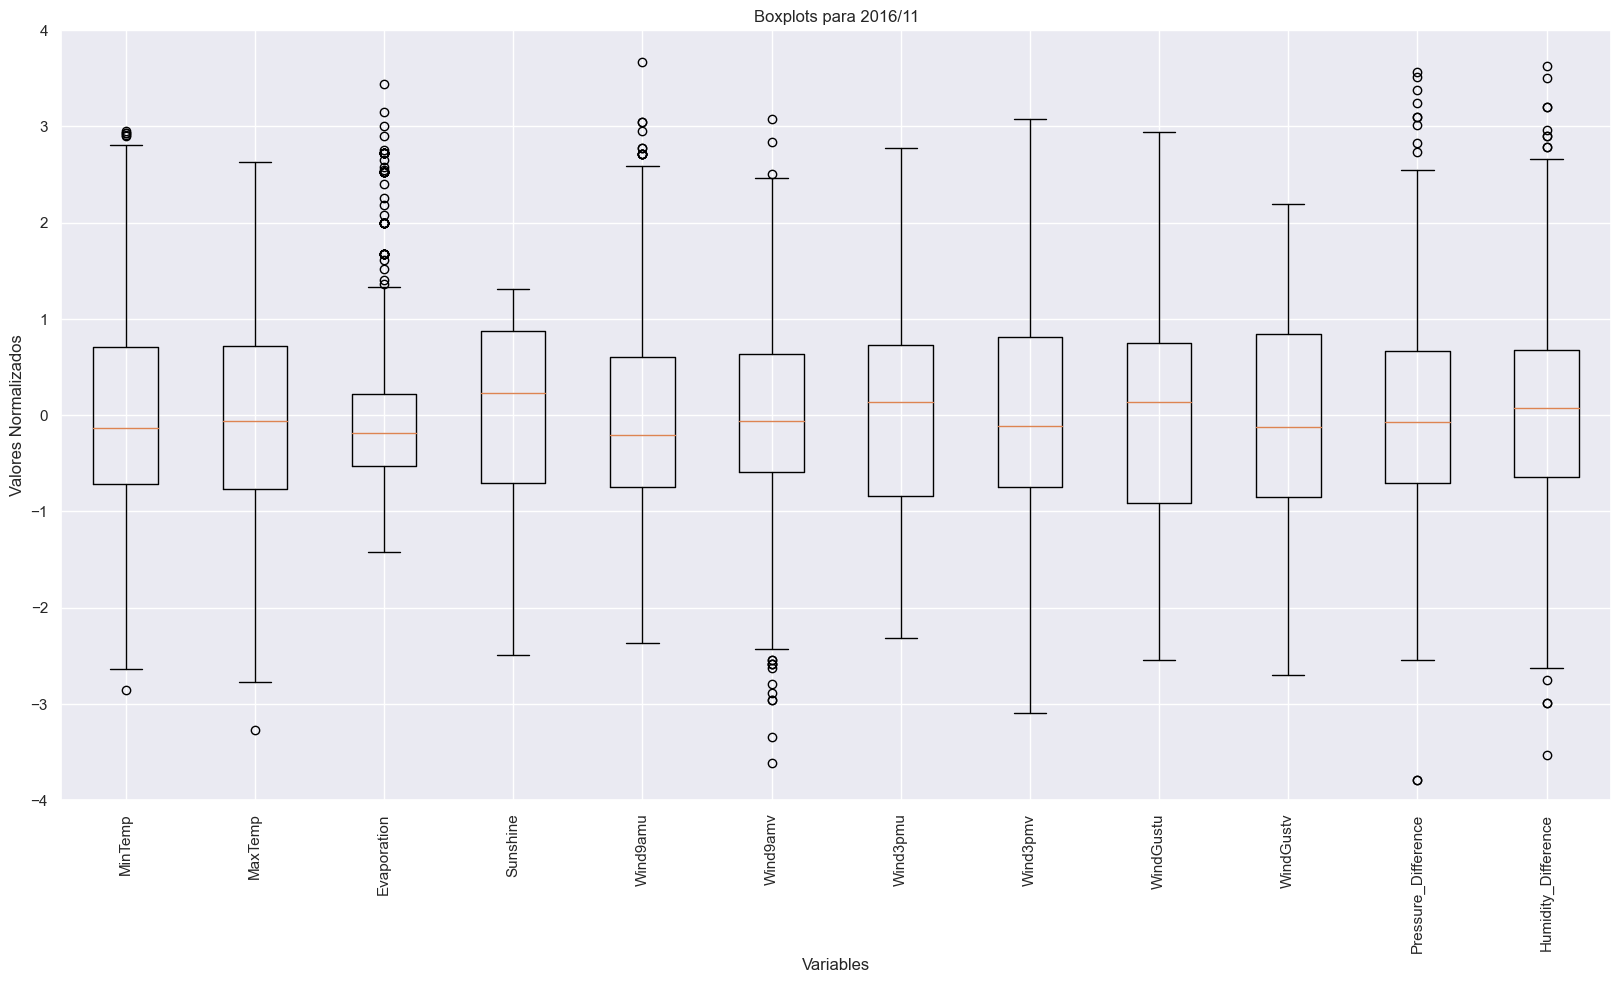

In [339]:
date_boxplots(df, year=2016, month=11)

## Eliminación de Outliers ##
Diseñamos una función que recibe el dataframe y nos elimina del mismo aquellos registros que presentan outliers en alguna de las variables númericas teniendo en cuenta un threshold que puede ser modificado para hacerlo mas o menos restrictivo. En este caso tomamos un valo de 2 lo que significa que eliminaremos aquellos valores que esten a mas de 2 veces el rango intercuartilico.

In [340]:
def remove_outliers(df, threshold=2):
    cleaned_df = df.copy()
    columns = df.drop(['RainTomorrow','RainfallTomorrow','RainToday','Rainfall'],axis=1).select_dtypes(include=[float, int])
    for column in columns:
        if column in df.columns:
            # Calcular el rango intercuartílico (IQR)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Definir los límites para identificar valores atípicos
            lower_limit = Q1 - threshold * IQR
            upper_limit = Q3 + threshold * IQR

            # Eliminar valores atípicos
            cleaned_df = cleaned_df[(cleaned_df[column] >= lower_limit) & (cleaned_df[column] <= upper_limit)]

    return cleaned_df

cleaned_df = remove_outliers(df)
print("Cantidad de datos removidos:", len(df) - len(cleaned_df))

Cantidad de datos removidos: 4985


## Análisis de Balance ##
Para analizar el balance necesitamos determinar si la distribución de las variables target, en este caso categóricas esta uniformemente distribuida. Para eso diseñamos el siguiente método. Pretendemos que los scores estén cerca de 0.5 lo que representaría una distribución uniforme de los datos.

In [341]:
def check_balance(df, target_columns):

    balance_scores = {}

    for column in target_columns:
        class_counts = df[column].value_counts()
        num_classes = len(class_counts)
        max_count = class_counts.max()
        balance_score = max_count / len(df)
        balance_scores[column] = balance_score

    return balance_scores

target_columns = ["RainTomorrow"]
balance_scores = check_balance(cleaned_df, target_columns)
print("Balance Scores:")
for column, score in balance_scores.items():
    print(f"{column}: {score}")

Balance Scores:
RainTomorrow: 0.7779069322831033


Dado que el valor de balance ronda el 0.8, el target RainTomorrow presentan una distribución no uniforme para sus respectivos valores. Esto quiere decir que el dataset no está balanceado.

## Selección de características y Estandarización ##

Para predecir la lluvia del día siguiente, decidimos trabajar con todas las variables (originales o transformadas) del dataset.

In [342]:
def dataframe_normalized(df):
    df_normalized = df.copy()
    scaler = StandardScaler()
    df_normalized[[ 'MinTemp', 'MaxTemp', 'Evaporation',
                    'Sunshine',
                    'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
                    'WindGustv', 'Pressure_Difference','Humidity_Difference']] = scaler.fit_transform(df_normalized[[ 
                                                                                        'MinTemp', 'MaxTemp', 'Evaporation',
                                                                                        'Sunshine',
                                                                                        'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
                                                                                        'WindGustv', 'Pressure_Difference',
                                                                                        'Humidity_Difference']])
    return df_normalized

def obtención_de_datos(df):
    df_copy=df.copy()
    skystate = {
        'Despejado' :               0,
        'Parcialmente Nublado' :    1,
        'Nublado' :                 2,
        'Muy Nublado' :             3
    }
    x=df_copy.drop(['RainToday','RainTomorrow','RainfallTomorrow','Date','Location','Cluster'],axis=1)
    x['Estado_Cielo'] = x['Estado_Cielo'].map(skystate)
    x=x[['MinTemp', 'MaxTemp', 'Evaporation',
        'Sunshine',
        'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
        'WindGustv', 'Pressure_Difference','Humidity_Difference','Estado_Cielo']].values.reshape(-1,13)
    y=df_copy['RainfallTomorrow'].values.reshape(-1,1)
    return x,y

x,y=obtención_de_datos(dataframe_normalized(cleaned_df))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Modelos y Rendimiento ##

In [343]:
def r2_score(y_true,_y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    ss_res = np.sum((y_true - _y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def mean_squared_error(y_true, _y_pred):
    mse = np.mean((y_true - _y_pred) ** 2)
    return mse

def mean_absolute_error(y_true, _y_pred):
    mae = np.mean(np.abs(y_true - _y_pred))
    return mae

### Regresión Global ###

In [344]:
# Crear un modelo de regresión lineal
lr = LinearRegression(fit_intercept=True)

# Ajustar el modelo a los datos de entrenamiento
lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = lr.predict(X_test)

# Calcular las métricas de evaluación
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Imprimir las métricas de evaluación
print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R^2: 0.1230
MSE: 63.1986
RMSE: 7.9498
MAE: 3.4573


### Gradient Descent ###

In [345]:
#Función Gradient Descent

def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))
    
    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W) 
        error_test = y_test - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

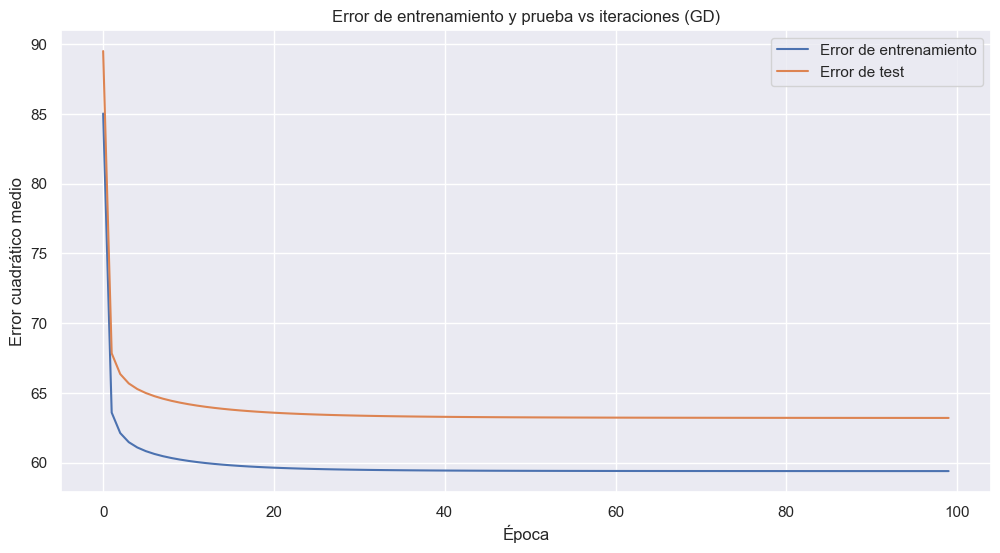

R^2: 0.1229
MSE: 63.2040
RMSE: 7.9501
MAE: 3.4551


In [346]:
W = gradient_descent(X_train, y_train, X_test, y_test, lr=0.1, epochs=100)

# Calcular predicciones en el conjunto de prueba
y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), W)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Para ambos modelos, las métricas de evaluación indican que el modelo actual tiene un rendimiento insatisfactorio. El coeficiente de determinación (R^2) es bajo, lo que significa que el modelo solo explica alrededor del 12.23% de la variabilidad en los datos. Además, el Error Cuadrático Medio (MSE) y la Raíz del Error Cuadrático Medio (RMSE) son relativamente altos, lo que sugiere que las predicciones del modelo tienen errores significativos en comparación con los valores reales. El Error Absoluto Medio (MAE) muestra un error absoluto promedio de alrededor de 3.40 unidades en la misma escala que los datos. En general, estos resultados indican que el modelo necesita mejoras o que la relación entre las características y la variable de respuesta no se está modelando de manera adecuada

## Regularización ##

Dado que el caso del dataframe normalizado y con outliers fue el que mejor se desempeño, trataremos de usar regularización en el mismo sin

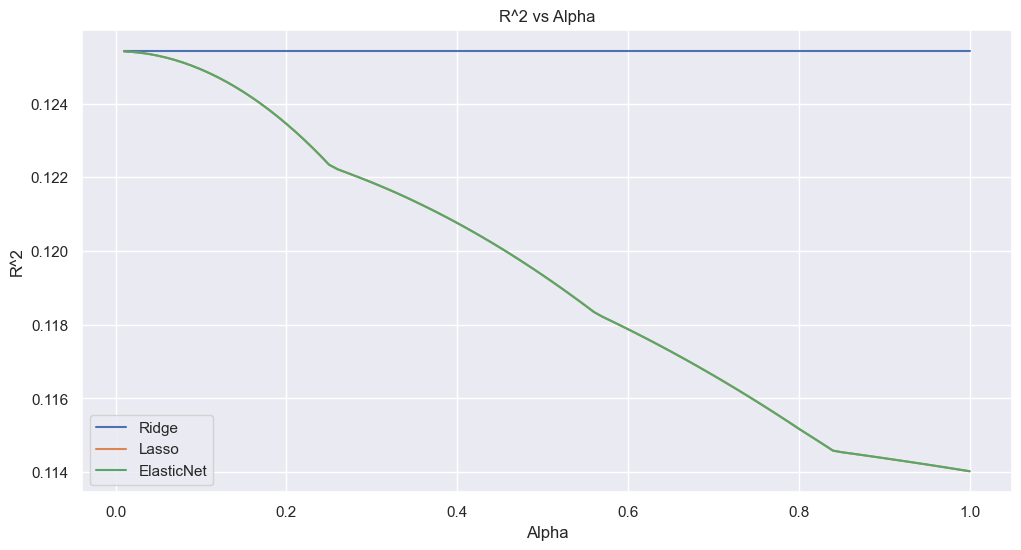

In [347]:
x,y=obtención_de_datos(cleaned_df)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

alphas = np.linspace(0.01, 1, 100)
score_ridge = []
score_lasso = []
score_elasticnet = []
for alpha in alphas:
    #print("Alpha:", alpha)
    # Crear modelos de regresión lineal, Lasso y Ridge
    lr = LinearRegression()
    lasso = Lasso(alpha)
    ridge = Ridge(alpha)
    elasticnet = ElasticNet(alpha, l1_ratio=1)

    # Ajustar modelos a los datos
    lr.fit(x, y)
    lasso.fit(x, y)
    ridge.fit(x, y)
    elasticnet.fit(x,y)

    score_ridge.append(ridge.score(x,y))
    score_lasso.append(lasso.score(x,y))
    score_elasticnet.append(elasticnet.score(x,y))

plt.figure(figsize=(12, 6))
plt.plot(alphas, score_ridge, label='Ridge')
plt.plot(alphas, score_lasso, label='Lasso')
plt.plot(alphas, score_elasticnet, label='ElasticNet')
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.legend()
plt.title('R^2 vs Alpha')
plt.show()

Text(0.5, 1.0, 'R^2 vs L1')

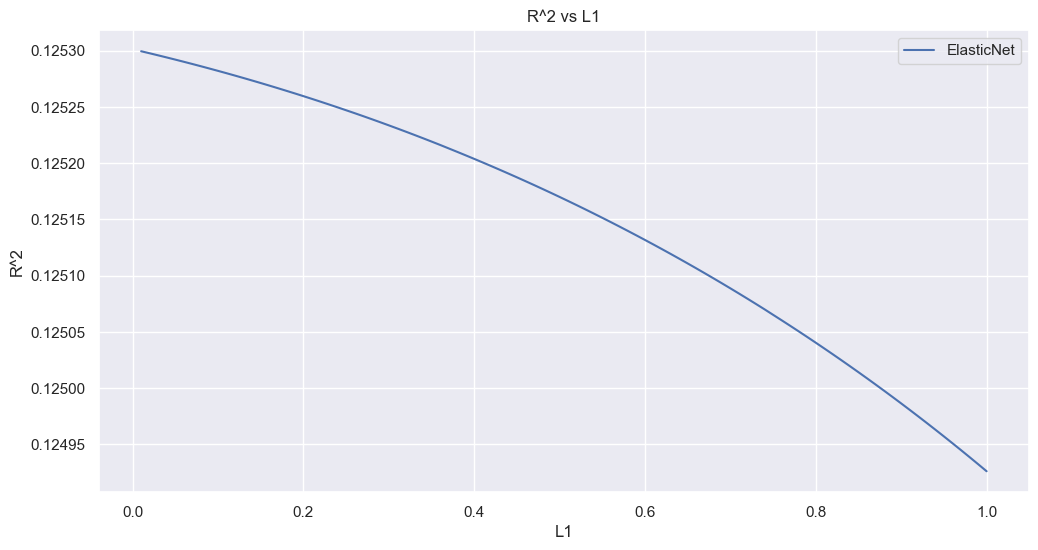

In [348]:
l1=np.linspace(0.01, 1, 100)
score_elasticnet = []
for l in l1:
    # Crear modelos de regresión lineal, Lasso y Ridge
    lr = LinearRegression()
    elasticnet = ElasticNet(alpha=0.1, l1_ratio=l)
    score_elasticnet.append(elasticnet.fit(x,y).score(x,y))

plt.figure(figsize=(12, 6))
plt.plot(l1, score_elasticnet, label='ElasticNet')
plt.xlabel('L1')
plt.ylabel('R^2')
plt.legend()
plt.title('R^2 vs L1')

La mala performance puede deberse, a distintos factores entre los que se encuentran:
- La transformación de los datos no fue la adecuada.
- Los outliers en los datos son mas de los que se esperaba y no se eliminaron correctamente, o inversamente, al eliminar ciertos outliers perdimos información importante.
- La cantidad de datos no es suficiente para entrenar un modelo de regresión lineal.
- La relación entre las variables y la variable target no es lineal.
- La cantidad de variables es muy grande y no todas son relevantes para el modelo.
- La cantidad de variables es muy grande y existe multicolinealidad entre ellas.

Nuestra hipótesis es que un modelo de regresión lineal no es el adecuado para este problema, ya que la relación entre las variables y la variable target no es lineal. Por lo tanto, se debería utilizar un modelo de regresión no lineal, como por ejemplo un modelo de regresión polinomial.